# rocketman lab

In [1]:
import sys
sys.path.insert(0, 'C:\\Data\\Dev\\PyCharmProjects\\rocketman\\src')

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd

from PIL import Image, ImageFile
import cv2
from peakdetect import peakdetect
import imagehash
from imagecluster import calc, io as icio, postproc

import sklearn as sk
from sklearn import cluster as cluster_models
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# load an preprocess image

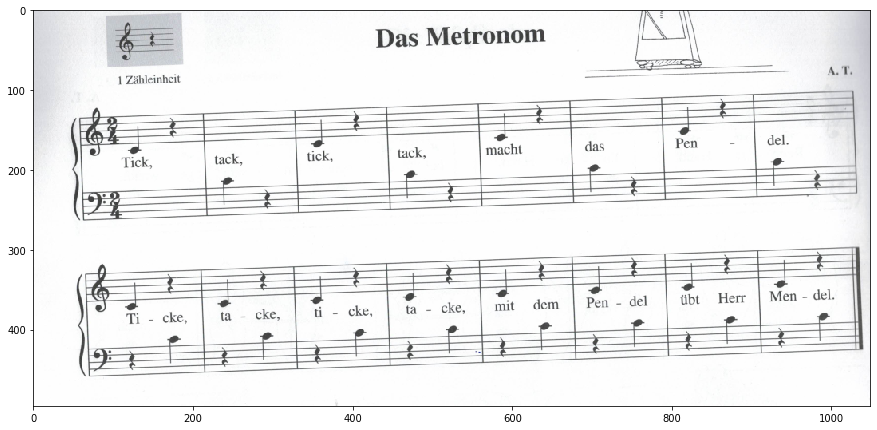

In [24]:
fname = "01"
ftype = ".png"
fpath = "C:\\Data\\Dev-Data\\music\\pieces\\"
fpath_lines = "C:\\Data\\Dev-Data\\music\\lines\\"
fpath_notes = "C:\\Data\\Dev-Data\\music\\notes\\"
filename = fpath + fname + ftype

def plotit (img):
    plt.figure(figsize = (15,8))
    plt.imshow(img,cmap = 'gray')
    plt.show()

image = plt.imread(filename)
plotit (image)

## brightening with openCV
https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html#gradients

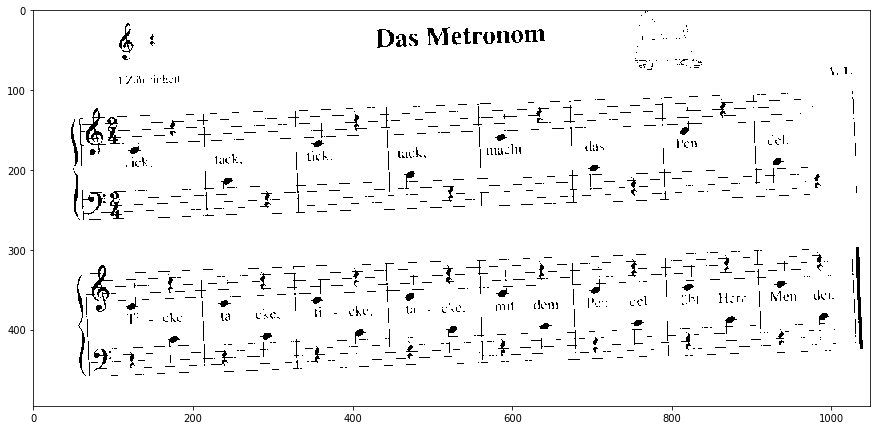

In [25]:
# gray scale
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#brighten
matrix = np.ones(image.shape, dtype = "uint8") * 1    
image = cv2.add(image, matrix, dtype = cv2.CV_8UC1)

# black & white
retval, image = cv2.threshold(image, 50, 255, cv2.THRESH_OTSU)
plotit (image)

## prepare image-cector in Y/X-coords for DBScan

In [26]:
height, width = image.shape

image_scatter = list()
for y in range (height):    
    for x in range (width):    
        pix = image[y,x]
        if pix == 0:
            image_scatter.append ([x,y])
image_scatter_array = np.array (image_scatter)

#plt.figure(figsize = (8,15))
#ax = plt.gca()
#ax.invert_yaxis()
#plt.scatter (image_scatter_array[:,0],image_scatter_array[:,1],s=1,c="black")

## clustering w/ DBScan

In [27]:
model = cluster_models.DBSCAN(eps=10)
clusters = model.fit_predict (image_scatter_array)

#plt.figure(figsize = (8,16))
#ax = plt.gca()
#ax.invert_yaxis()
#plt.scatter (image_scatter_array[:,0],image_scatter_array[:,1],s=1,c=clusters)

## display cluster

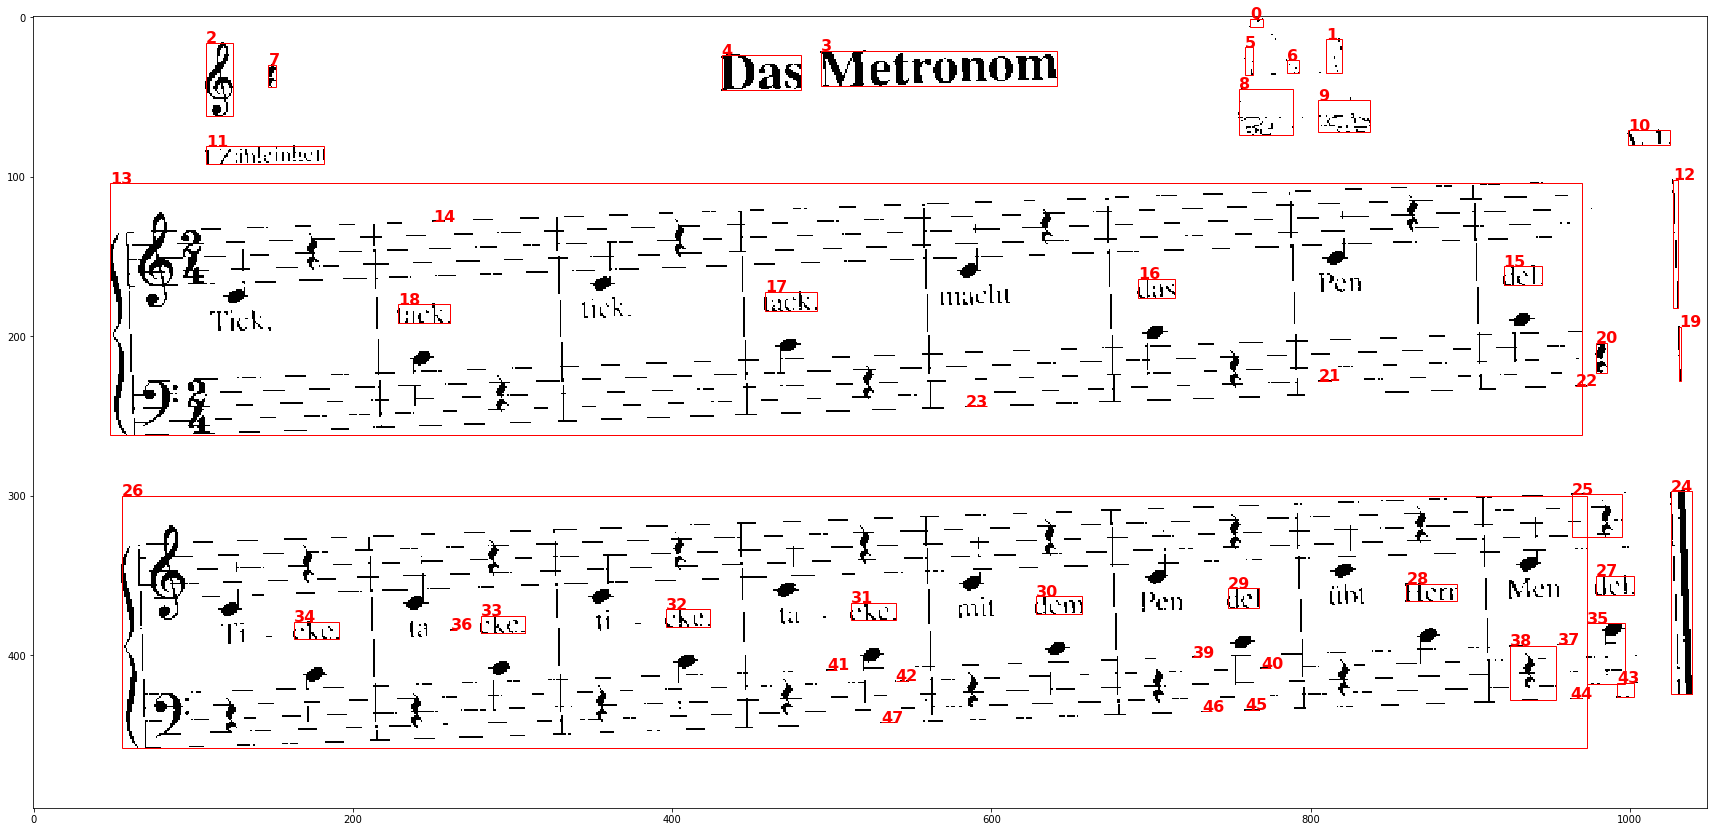

49 CLUSTER


In [28]:
# ALTERNATIVE 1: AUF DEM ORIGINALS
fig,ax = plt.subplots(1,figsize = (30,16))
ax.imshow(image, cmap="gray")

# ALTERNATIVE 2: AUF DEM SCATTERPLOT
#fig,ax = plt.subplots(1,figsize = (8,16))
#ax = plt.gca()
#ax.invert_yaxis()
#ax.scatter (image_scatter_array[:,0],image_scatter_array[:,1],s=1,c=clusters)

# RECHTECKE PRO CLUSTER BERECHNEN UND ZEICHNEN
# STEP 0: die Rechtecke für die Cluster werden später für die Vereinigung von Cluster benötigt
class Rectangle:
    def __init__(self, min_x, min_y, max_x, max_y, identificator):
        self.min_x = min_x
        self.min_y = min_y
        self.max_x = max_x
        self.max_y = max_y
        self.identificator = identificator

    def __repr__(self):
        return str(self.identificator) + ": " + str(self.min_x) + "/" + str(self.min_y) + "/" + str(self.max_x) + "/" + str(self.max_y)
        
    def intersects(self, other):
        return not (self.max_x < other.min_x or 
                    self.max_y < other.min_y or 
                    self.min_x > other.max_x or 
                    self.min_y > other.max_y)
    
    def vintersects(self, other):
        return      (self.max_x > other.min_x and other.max_x > self.min_x)
rects = list()
    
# STEP 1: für jedes identifizierte cluster alle Positionen in ein eigenes array übertragen
y = np.array (clusters)
num_cluster = y.max()

cluster_image_array = list()
for i in range (num_cluster):
    c = np.array([image_scatter_array[x] for x in range (1,y.shape[0]) if y[x]==i])
    
    # Sonderbehandlung für Aussreisser
    min_x = c[:,1].min()
    max_x = c[:,1].max()
    min_y = c[:,0].min()
    max_y = c[:,0].max()    
    if not (max_x-min_x) > (height - 50):
        cluster_image_array.append (c)
    
# STEP 2: aus dem array für das Cluster die min und max Werte der X und Y-Position ermitteln
for i in range (len(cluster_image_array)):
    cluster_image = cluster_image_array[i]

    min_x = cluster_image[:,1].min()
    min_y = cluster_image[:,0].min()
    max_x = cluster_image[:,1].max()
    max_y = cluster_image[:,0].max()

    r = Rectangle(min_x, min_y, max_x, max_y, i)
    rects.append (r)
    
    rect = patches.Rectangle((min_y,min_x),(max_y-min_y), (max_x-min_x),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch (rect)
    ax.text (min_y, min_x, str(i), fontdict={'weight':'bold', 'size':16}, color="red")

plt.show()
print (str(len (cluster_image_array)+1) + " CLUSTER")

## combine overlapping cluster

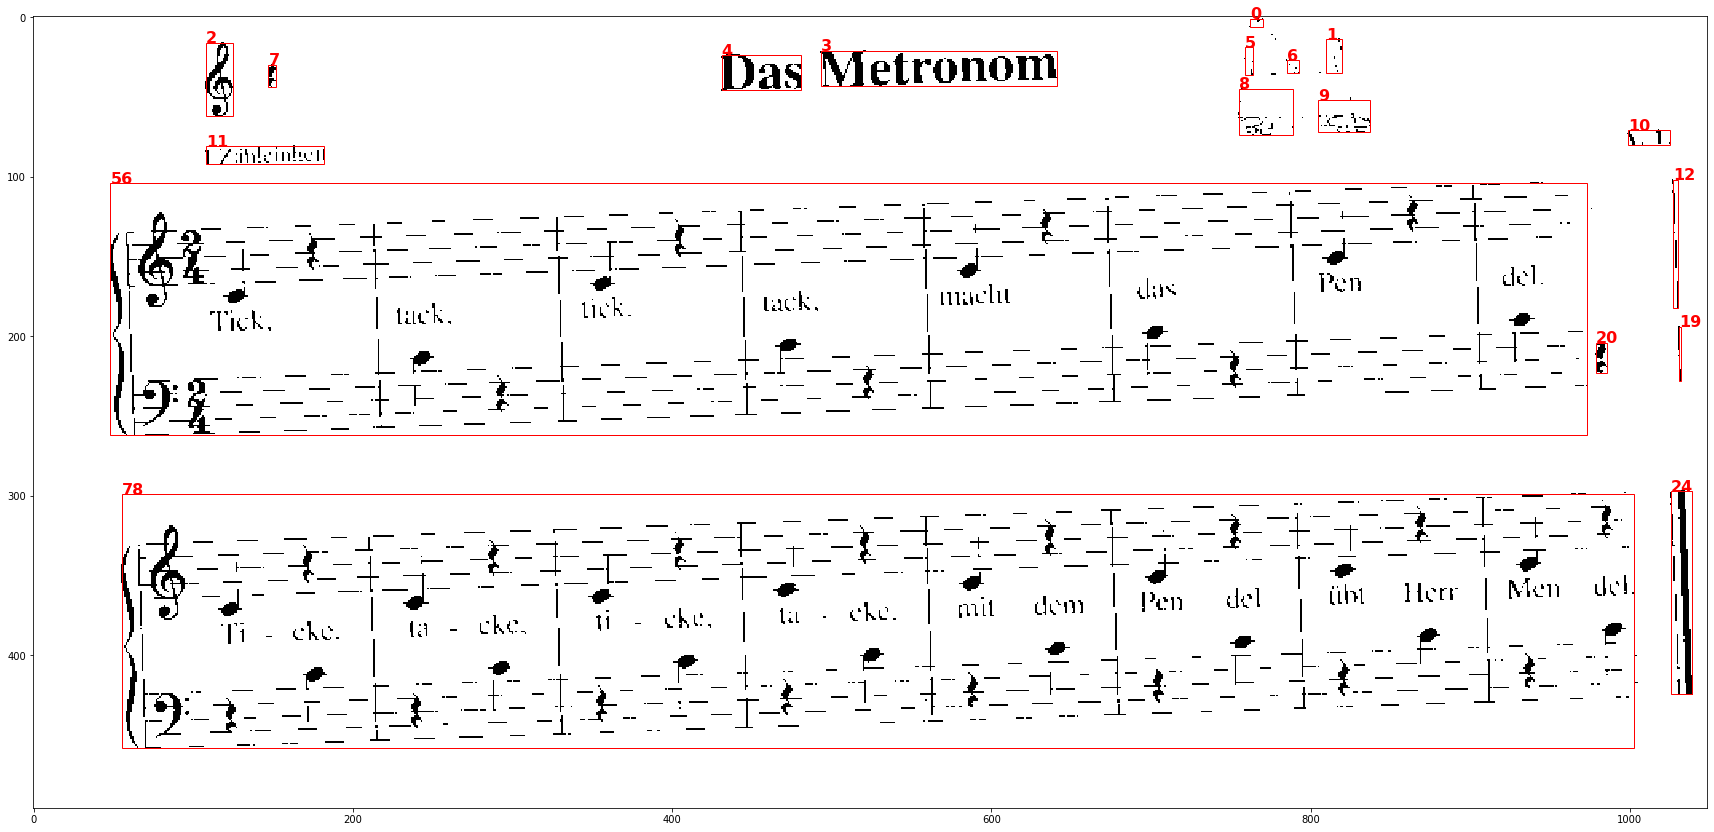

In [29]:
cnt = 0 
num_rects = len (rects)
while cnt<len(rects):
    rect = rects[cnt]
    # print (str(cnt)+": "+str(rect.identificator))
    for cnt2 in range(cnt + 1, len(rects)):
        rect2 = rects[cnt2]
        if rect.intersects (rect2):
            num_rects = num_rects + 1
            #print ("cluster ", rect.identificator, " collides with ", rect2.identificator)
            #print ("-- add: ", num_rects)
            #print ("-- remove", rect.identificator)
            #print ("-- remove", rect2.identificator)

            ci1 = cluster_image_array[cnt]
            ci2 = cluster_image_array[cnt2]
            ci = np.concatenate ((ci1, ci2))
            cluster_image_array.append (ci)
            
            min_y = ci[:,0].min()
            max_y = ci[:,0].max()
            min_x = ci[:,1].min()
            max_x = ci[:,1].max()
            r = Rectangle(min_x, min_y, max_x, max_y, num_rects)
            rects.append (r)
            
            del (cluster_image_array[cnt])
            del (cluster_image_array[cnt2-1])

            del (rects[cnt])
            del (rects[cnt2-1])

            cnt = -1
            break
    cnt = cnt + 1

# neue Zeichnung
fig,ax = plt.subplots(1,figsize = (30,16))
ax.imshow(image, cmap="gray")
for i in range (len(cluster_image_array)):
    cluster_image = cluster_image_array[i]
    min_y = cluster_image[:,0].min()
    max_y = cluster_image[:,0].max()
    min_x = cluster_image[:,1].min()
    max_x = cluster_image[:,1].max()
    rect = patches.Rectangle((min_y,min_x),(max_y-min_y), (max_x-min_x),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch (rect)
    ax.text (min_y, min_x, str(rects[i].identificator), fontdict={'weight':'bold', 'size':16}, color="red")
plt.show()

## capture single line

0


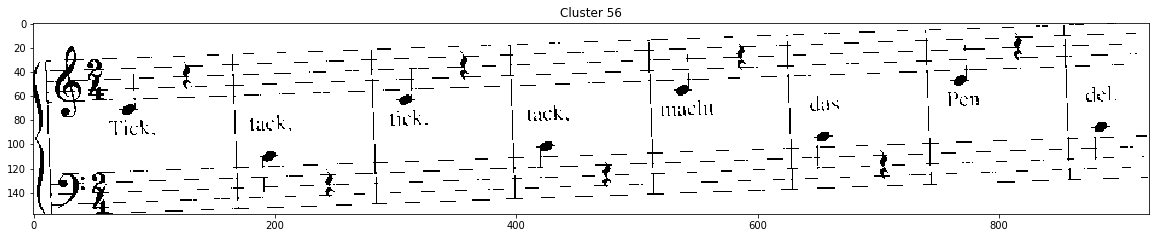

1


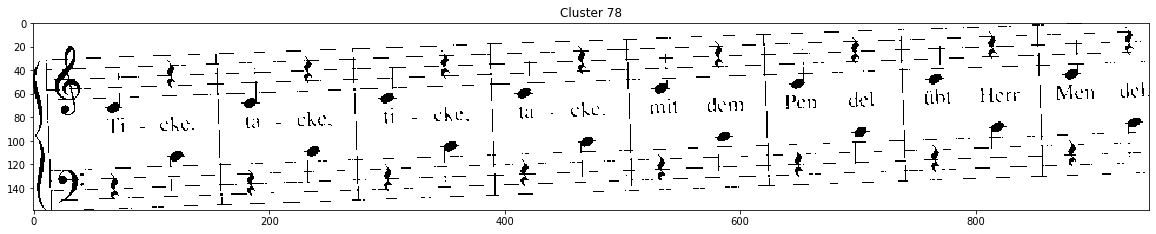

2  images identitfied


In [30]:
min_height = 10
min_width = 30

selected_images = []

cnt = 0
for i in range (len(cluster_image_array)):
    cluster_image = cluster_image_array[i]
    min_y = cluster_image[:,0].min()
    max_y = cluster_image[:,0].max()
    min_x = cluster_image[:,1].min()
    max_x = cluster_image[:,1].max()
    if max_y > min_y + min_height and max_x > min_x + min_width and max_y- min_y> max_x- min_x:
        print (cnt)
        selected_images.append (image[min_x:max_x,min_y:max_y])
        plt.figure(figsize = (20,10))
        plt.imshow(image[min_x:max_x,min_y:max_y], cmap="gray")
        plt.title ("Cluster {}".format(rects[i].identificator))
        plt.savefig (fpath_lines+fname+"_"+str(cnt)+ftype)
        plt.show()
        cnt = cnt + 1 

print (len(selected_images)," images identitfied")

## capture single note

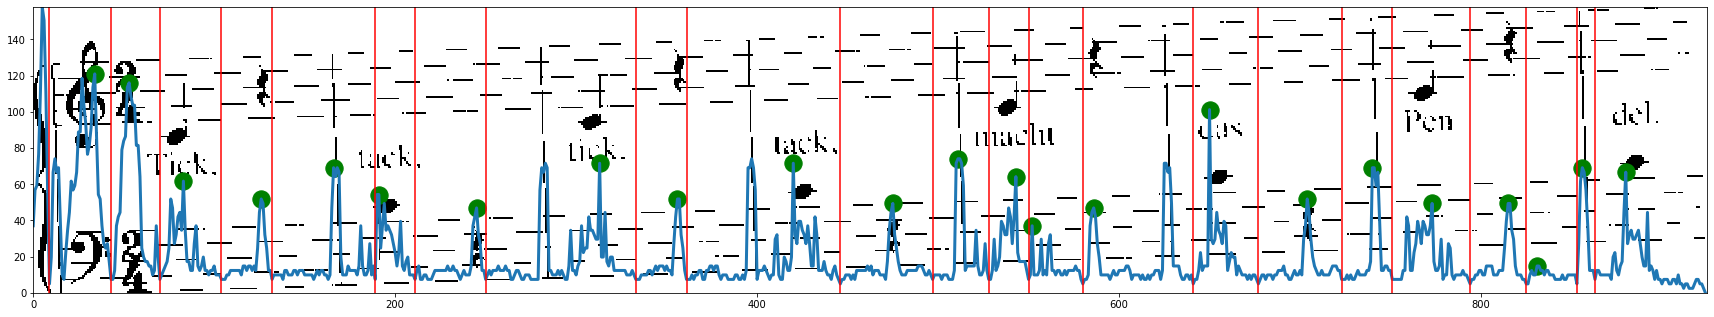

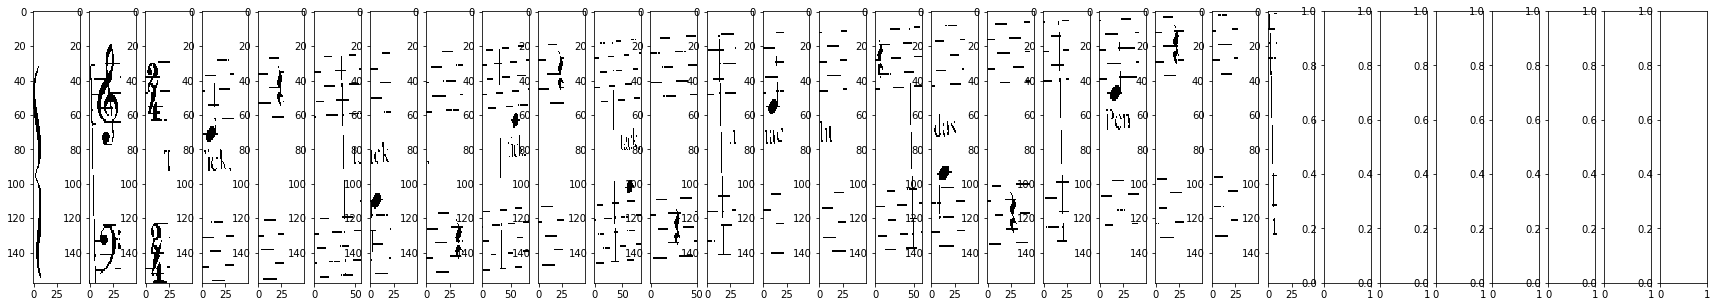

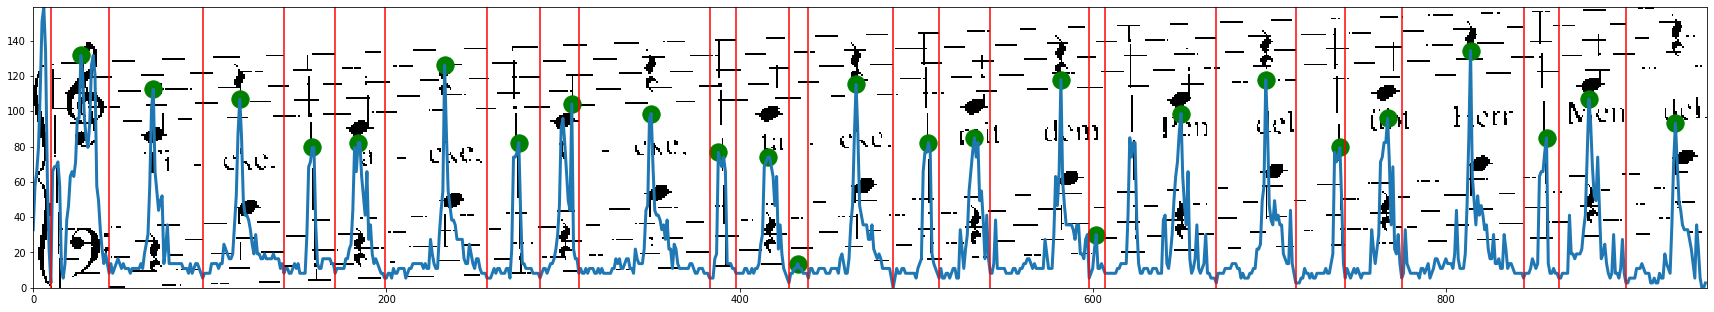

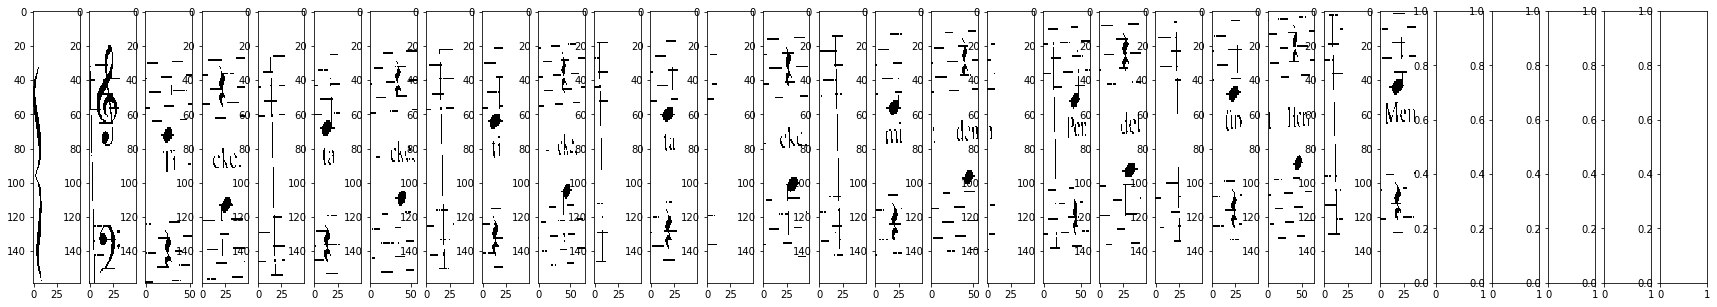

In [31]:
crop_images = []

for cnt in range (0,len (selected_images)):
    
    img = selected_images[cnt]
    img_height = img.shape[0]
    img_width = img.shape[1]

    # calcuate density
    x = 0
    density_array = []
    while x < img_width:
        density = sum (255-img[:,x])
        density_array.append (density)
        x = x + 1

    # rescale density to value 0 - 1
    max_val = max (density_array)  
    density_array = (density_array / max_val) 

    # detect lows
    peaks = peakdetect(density_array, lookahead=15)

    lows = np.asarray (peaks[1])
    xl = lows[:,0]
    yl = lows[:,1]

    highs = np.asarray(peaks[0])
    xh = highs[:,0]
    yh = highs[:,1]

    fig, ax = plt.subplots(1,figsize = (30,16))
    ax.imshow(img, cmap='gray', extent=[0, img_width, 0, img_height])
    ax.plot (density_array*img_height, linewidth=3)
    ax.scatter (xh,yh*img_height,s=300,c="green")
    for low in lows:
        ax.axvline (low[0],0,img_height,color="red")
    plt.show ()

    # crop single notes
    i = 0
    x1 = 0
    for low in lows:
        x2 = int(low [0])
        crop_img = img[0:img_height, x1:x2]
        # hasving the same image shape will improve performance
        smaller_than_50 = 50-(x2-x1)
        if (smaller_than_50) > 0:
            empty_array = np.full ((img_height,smaller_than_50),255)
            crop_img = np.concatenate((crop_img, empty_array), axis=1)
        crop_images.append (crop_img)
        x1 = x2
        i = i + 1  
        
        ImageFile.MAXBLOCK = 2**20
        tmp = Image.fromarray (crop_img)
        tmp.convert('RGB').save(fpath_notes+fname+"_"+str(cnt)+"_"+str(i)+ftype)
        
        ''' Alternative über matplotlib
        fig = plt.figure()
        plt.box(False)
        plt.xticks ([])
        plt.yticks ([])
        plt.imshow(crop_img,aspect='auto',cmap="gray")       
        plt.savefig (fpath_notes+fname+"_"+str(cnt)+"_"+str(i)+ftype)         
        plt.close(fig)        
        '''
    
    # print crops
    fig, axs = plt.subplots(1, 30, figsize=(30,5))
    for j in range (min(30,len(lows))):
        axs[j].imshow(crop_images[len(crop_images)-i+j],aspect='auto', cmap="gray")      
    plt.show()
    

# Apply different clustering approaches for single note

In [32]:
# the more clusters the higher the precisions
num_cluster = 10

# num of entries displayed per line
num_entries = min (30, len(lows))

## calculate similarity based on images hashes
https://github.com/JohannesBuchner/imagehash

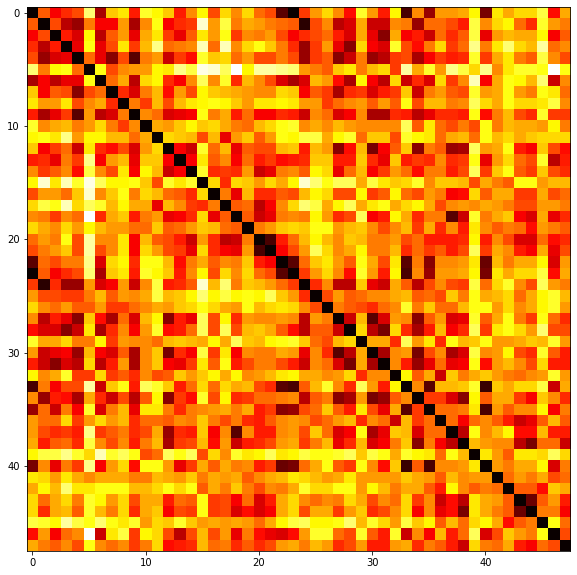

In [12]:
# calculate image hash
image_hashes = []
for crop_image in crop_images:
    image_hash = imagehash.average_hash(Image.fromarray(crop_image))
    #image_hash = imagehash.dhash(Image.fromarray(crop_image))
    #image_hash = imagehash.phash (Image.fromarray(crop_image))
    #image_hash = imagehash.whash(Image.fromarray(crop_image))
    image_hashes.append (image_hash)

# calulate image difference matrix
l = len(image_hashes)
m = np.empty ((l,l))
for i in range (l):
    for j in range (l):
        m[i,j] = image_hashes[i] - image_hashes[j]

plt.figure(figsize = (10,10))
plt.imshow (m, cmap="hot")
plt.show ()

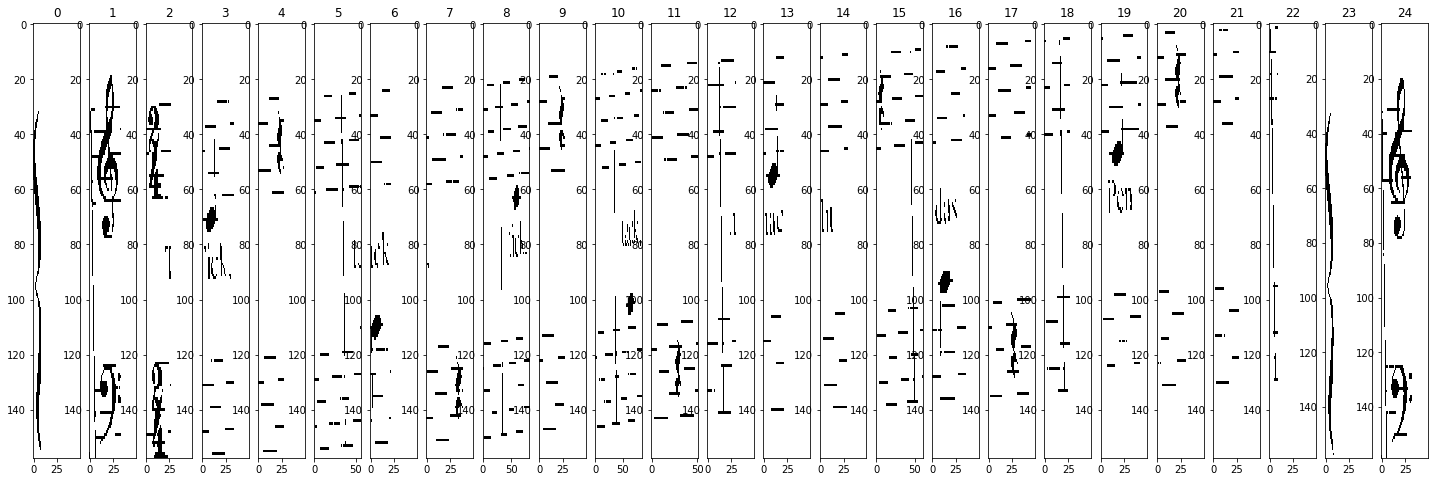

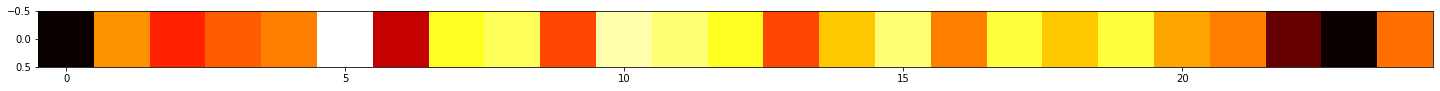

In [13]:
# display single line
offset = 0
fig, axs = plt.subplots(1, num_entries, figsize=(num_entries,8))
for i in range (num_entries):
    axs[i].set_title (str(offset+i))
    axs[i].imshow(crop_images[offset+i], aspect='auto', cmap="gray")
plt.show()

plt.figure(figsize = (num_entries,2))
plt.imshow (m[offset:offset+1,offset:offset+num_entries], cmap="hot")
plt.show ()

In [14]:
# convert to bit array for clustering
bit_array = []
for image_hash in image_hashes:
    bits = [1 if b == True else 0 for l in image_hash.hash for b in l]
    bit_array.append (bits)
X = bit_array
    
# option: with PCA reduced data
#X = PCA(n_components=2).fit_transform(X) 

# run clustering
k = AgglomerativeClustering(n_clusters=num_cluster).fit (X)
print (k.labels_)

[5 4 7 7 4 3 7 4 3 4 0 6 4 2 2 6 1 6 1 0 2 2 5 5 4 3 3 4 7 9 4 7 9 5 4 5 9
 1 1 0 5 0 8 1 1 8 2 1]


cluster:  0


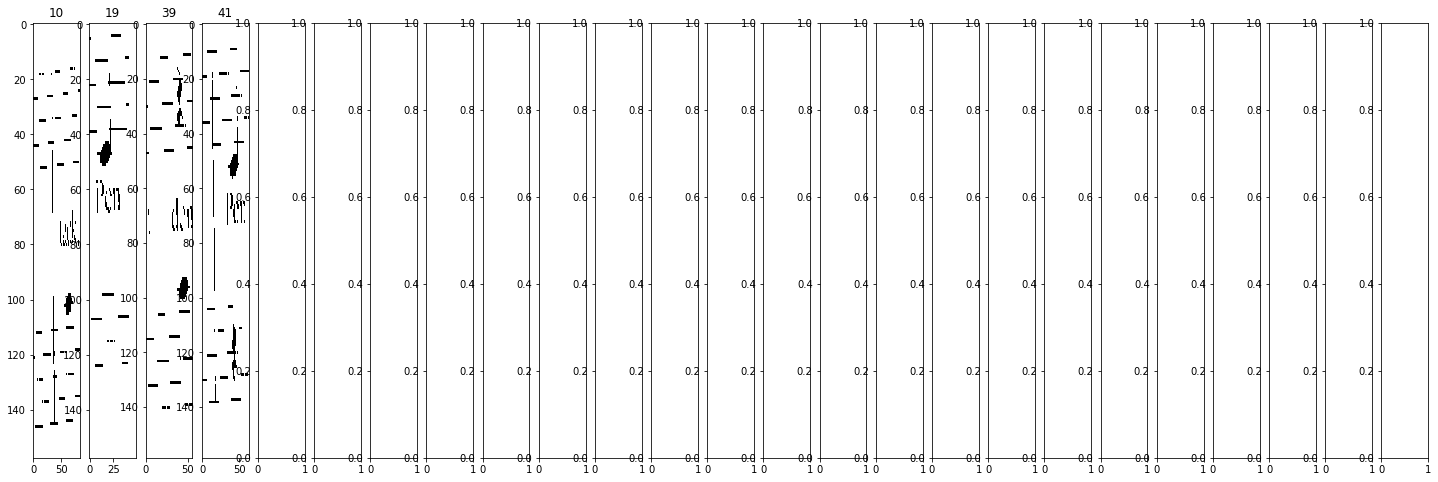

cluster:  1


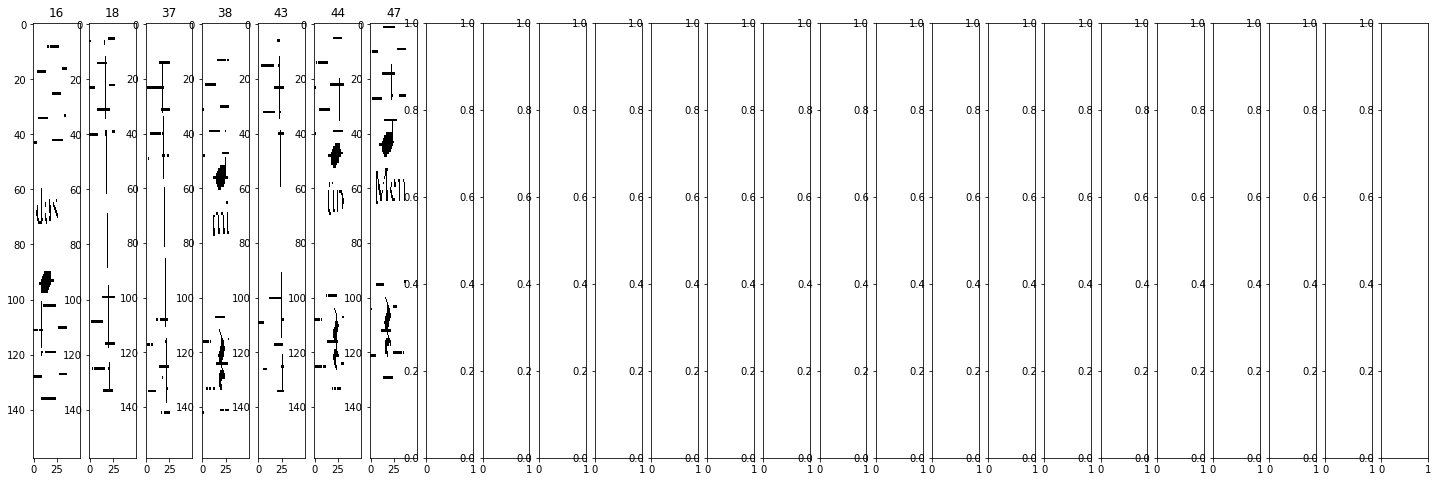

cluster:  2


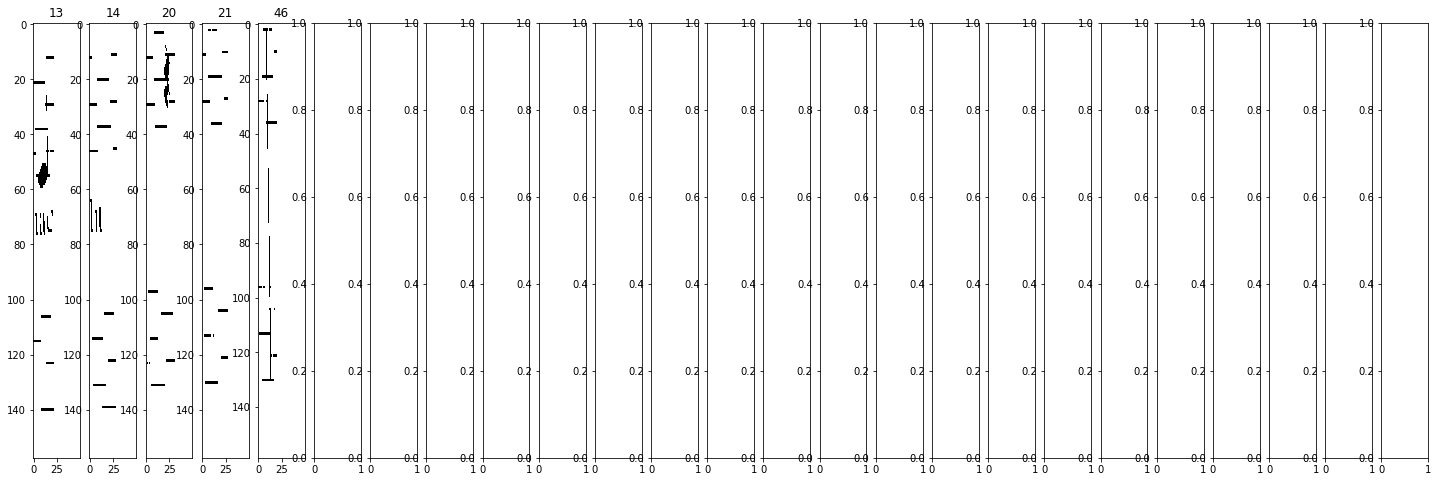

cluster:  3


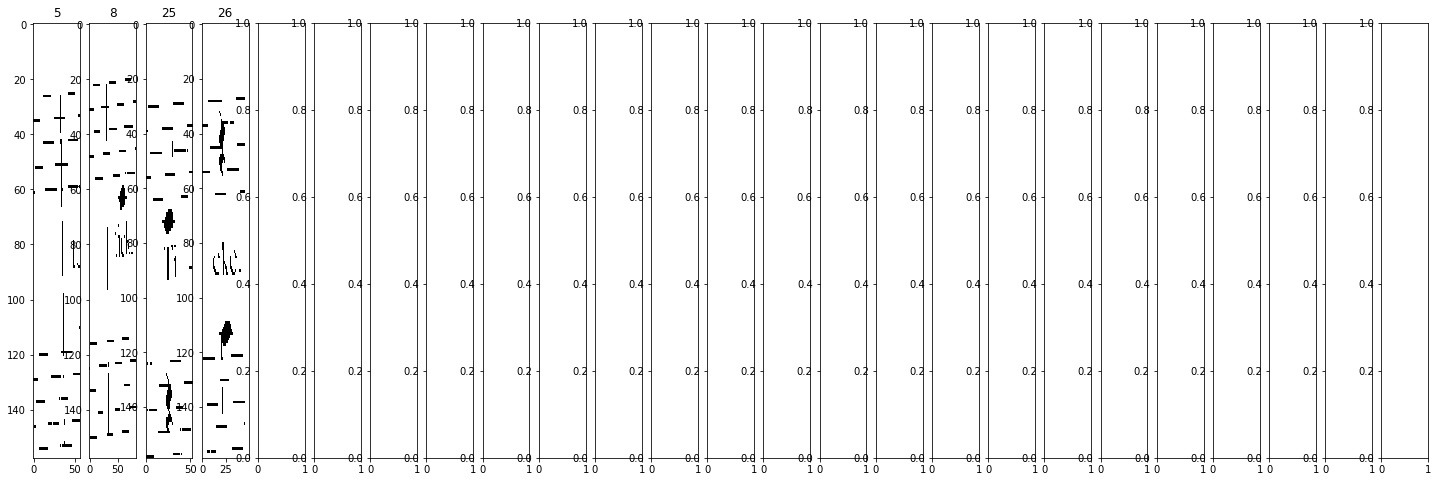

cluster:  4


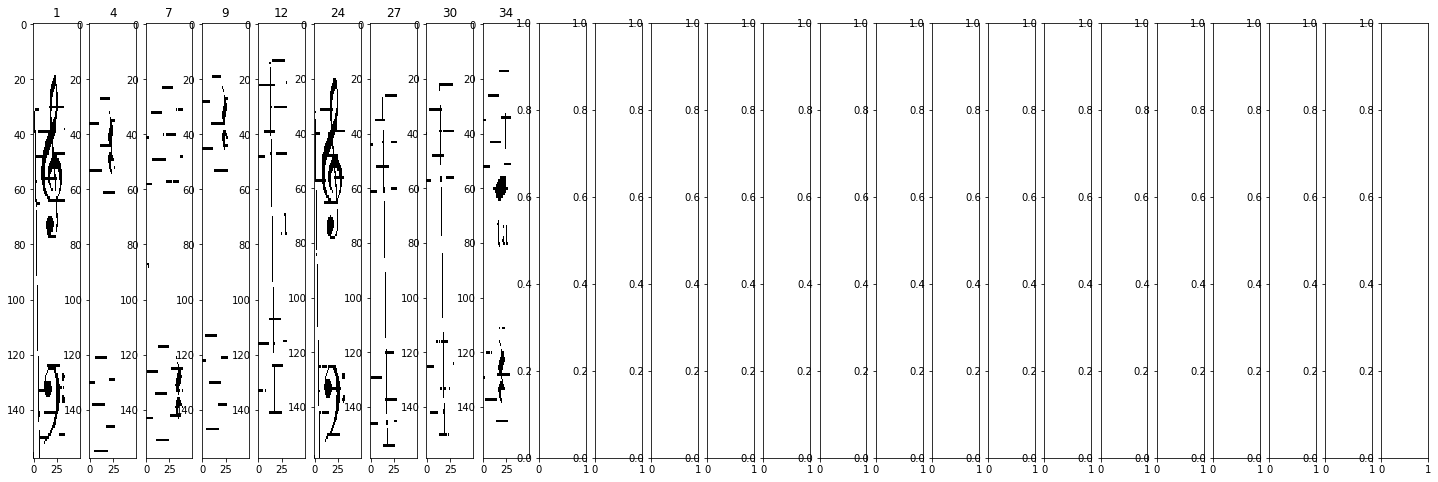

cluster:  5


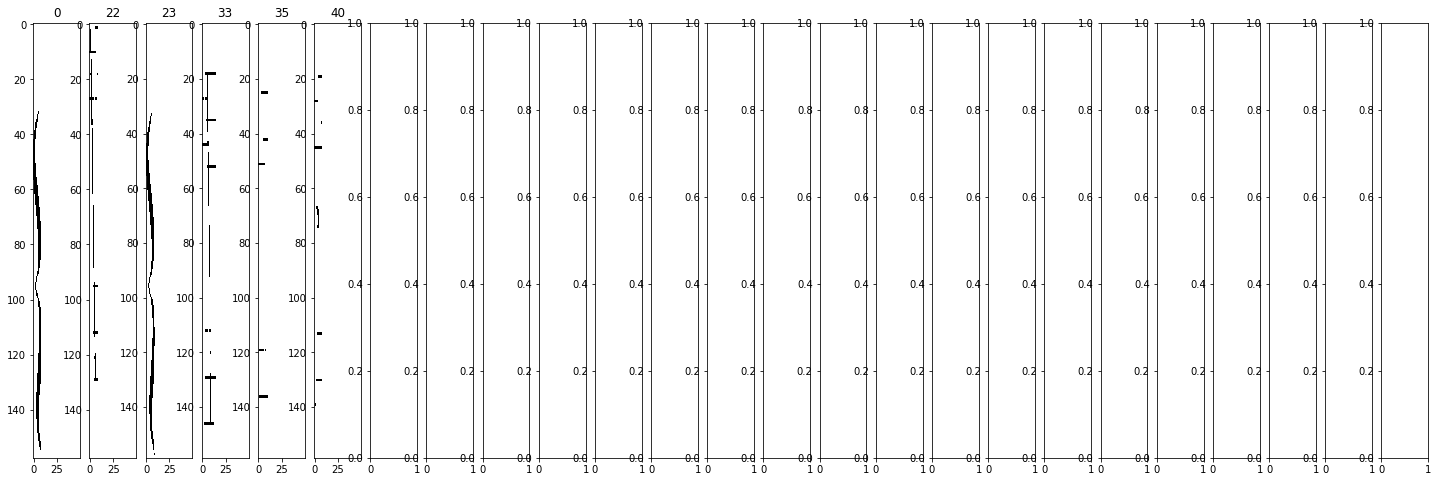

cluster:  6


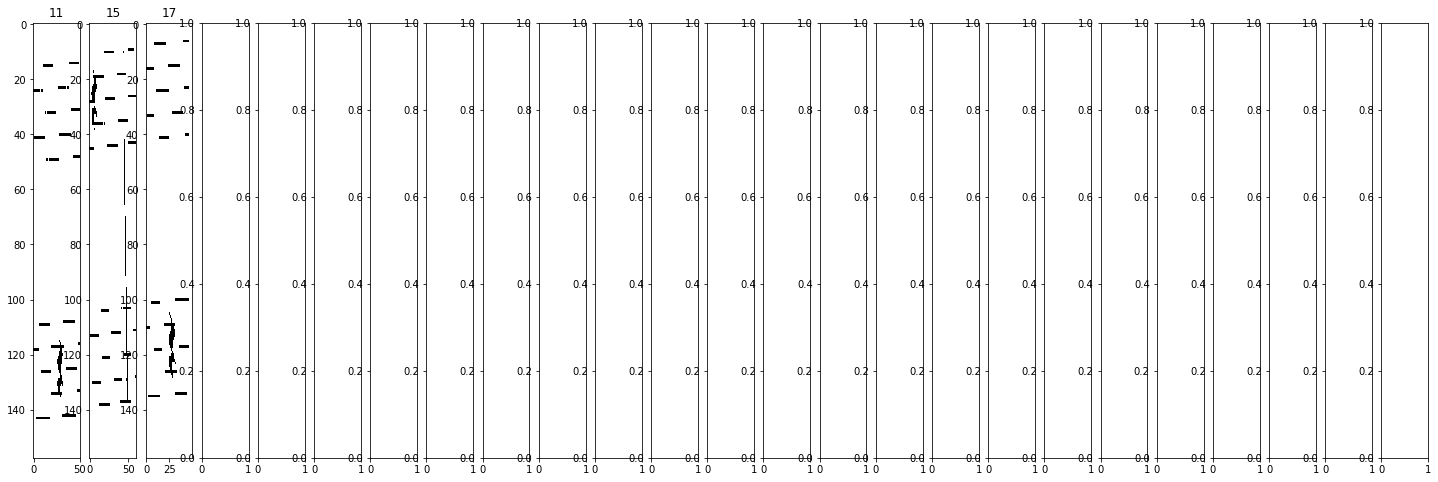

cluster:  7


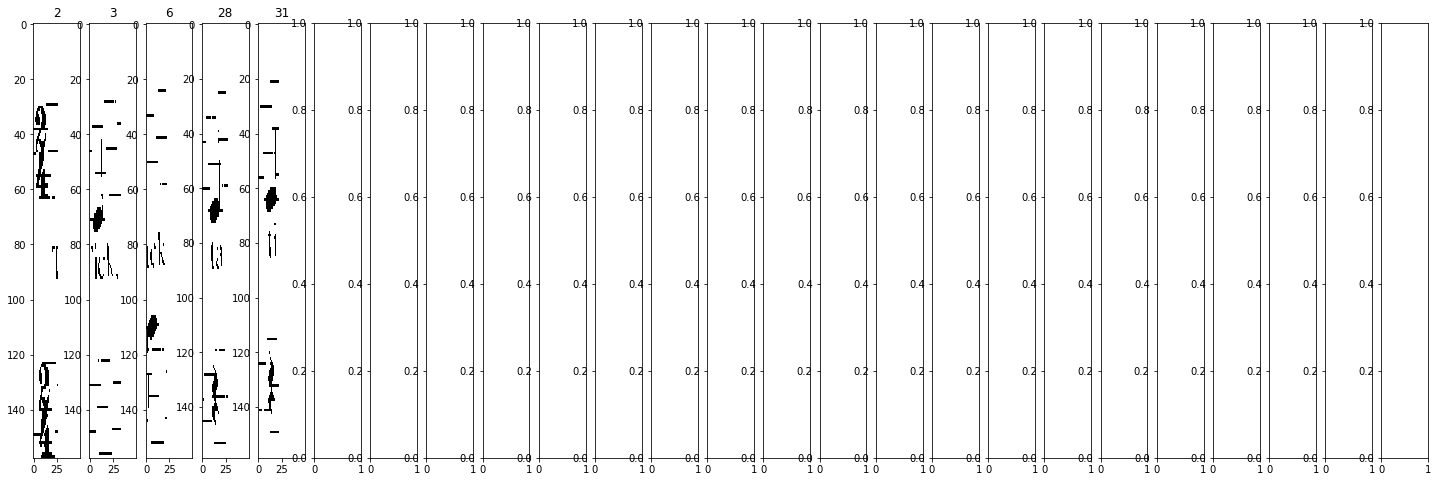

cluster:  8


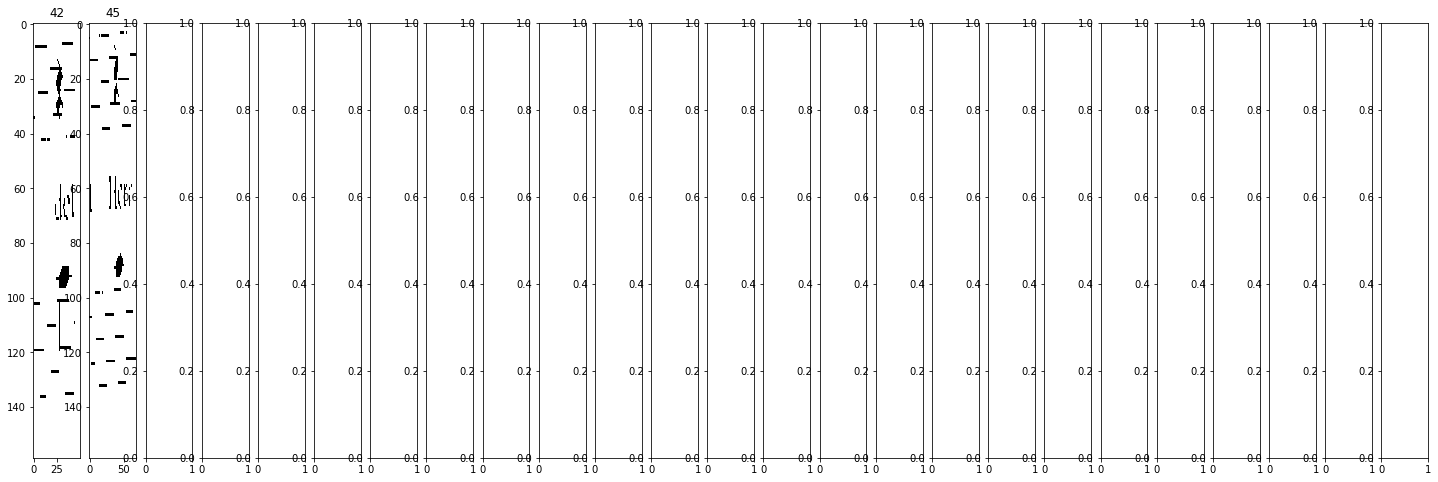

cluster:  9


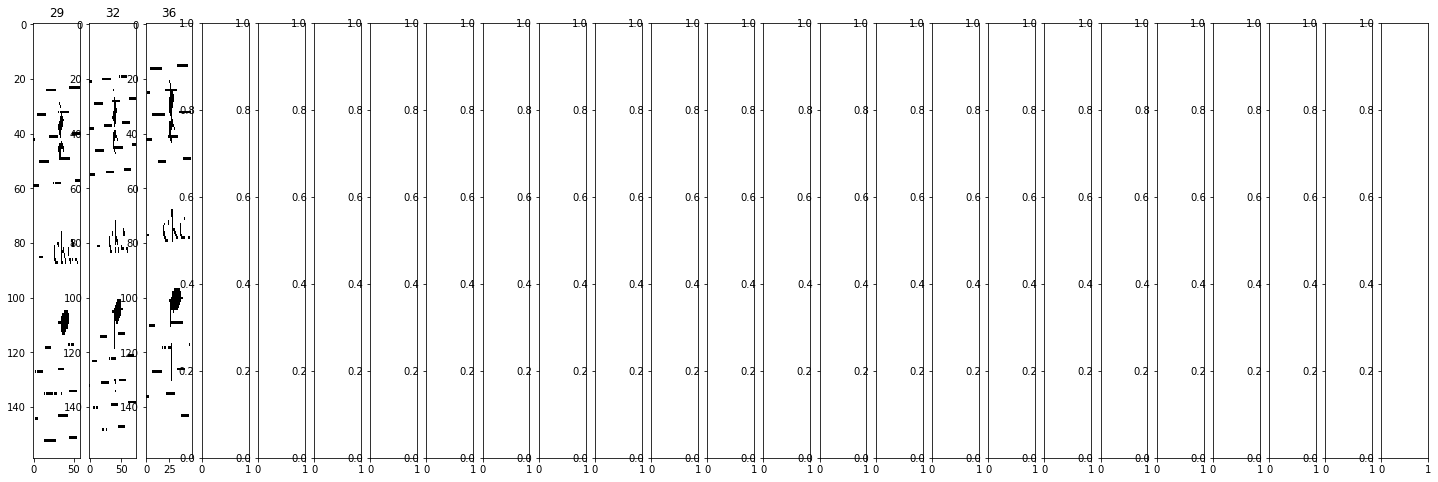

In [15]:
# display images per cluster

idx = [[] for i in range(num_cluster)]
for i in range (len (k.labels_)):
    c = k.labels_[i]
    idx[c].append (i)

for selected_cluster in range (num_cluster):
    print ("cluster: ", selected_cluster)
    fig, axs = plt.subplots(1, num_entries, figsize=(num_entries,8))
    for i in range (min(num_entries,len(idx[selected_cluster]))):
        clustered_img = idx[selected_cluster][i]
        axs[i].set_title (str(clustered_img))
        axs[i].imshow(crop_images[clustered_img], aspect='auto', cmap="gray")
    plt.show()

## cluster images by pixels
https://towardsdatascience.com/color-difference-clustering-on-pokemon-images-68c6f0a3245b

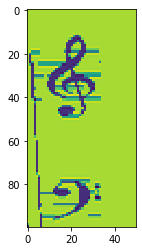

In [16]:
# resize images to work with clustering

img_width = 50
img_height = 100

image_list = []
for crop in crop_images:
    img = Image.fromarray (crop)
    img = img.resize ((img_width, img_height), Image.ANTIALIAS)
    image_list.append(np.array(img))

image_array = np.stack (image_list)

plt.imshow (image_array[1])
plt.show ()

# reshape for clustering

x,y,z = image_array.shape
X = image_array.reshape (x,y*z)

In [17]:
# option: with PCA reduced data
#X = PCA(n_components=2).fit_transform(X) 

# run clustering
k = AgglomerativeClustering(n_clusters=num_cluster).fit (X)
print (k.labels_)

[5 4 7 8 8 9 2 2 3 8 9 2 0 8 8 8 0 2 3 3 8 8 8 5 4 0 1 0 0 2 8 0 2 8 0 8 2
 3 0 6 8 9 6 2 3 6 8 1]


cluster:  0


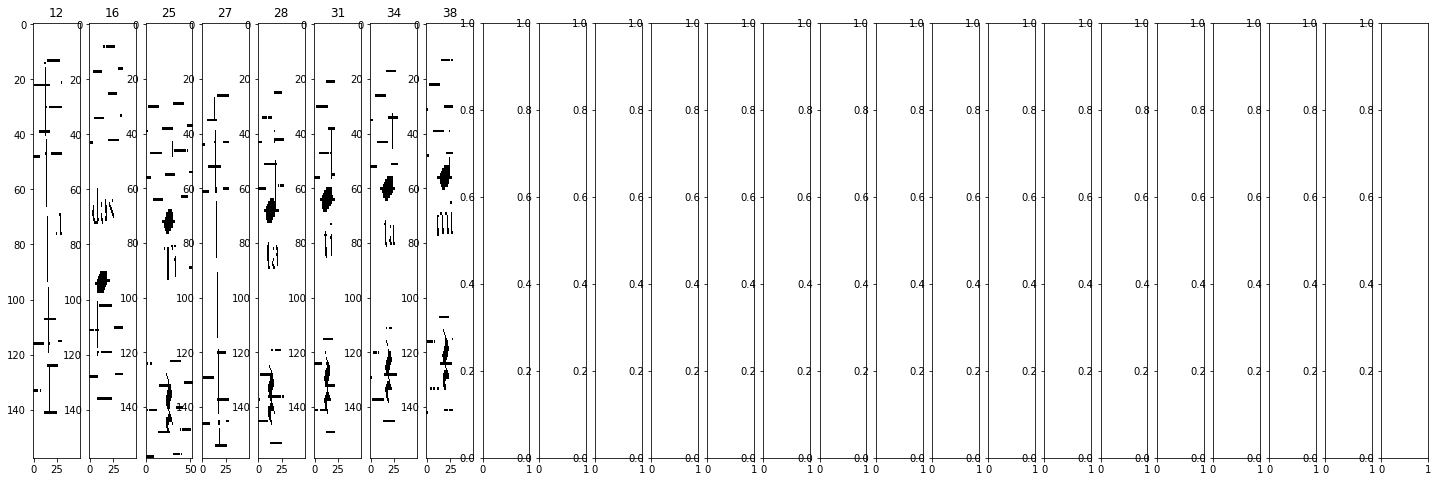

cluster:  1


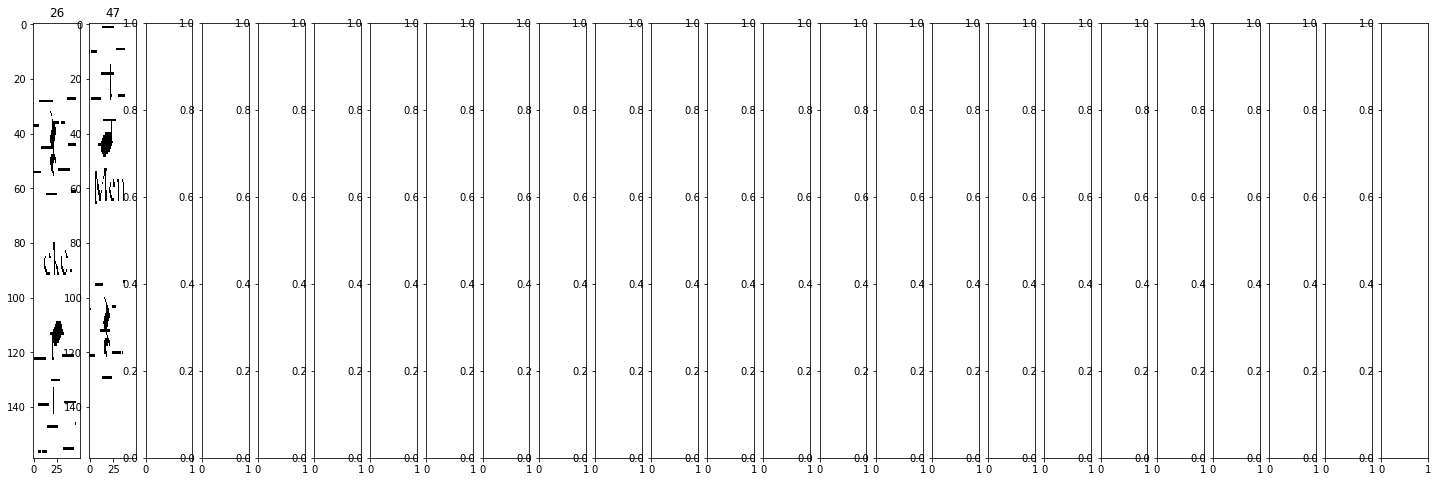

cluster:  2


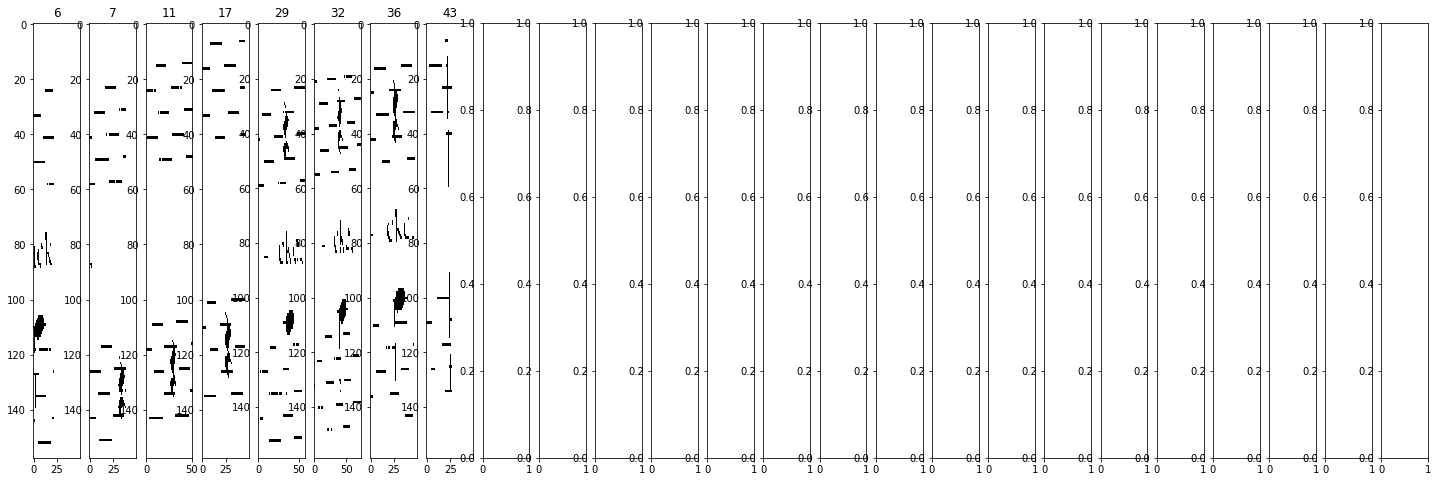

cluster:  3


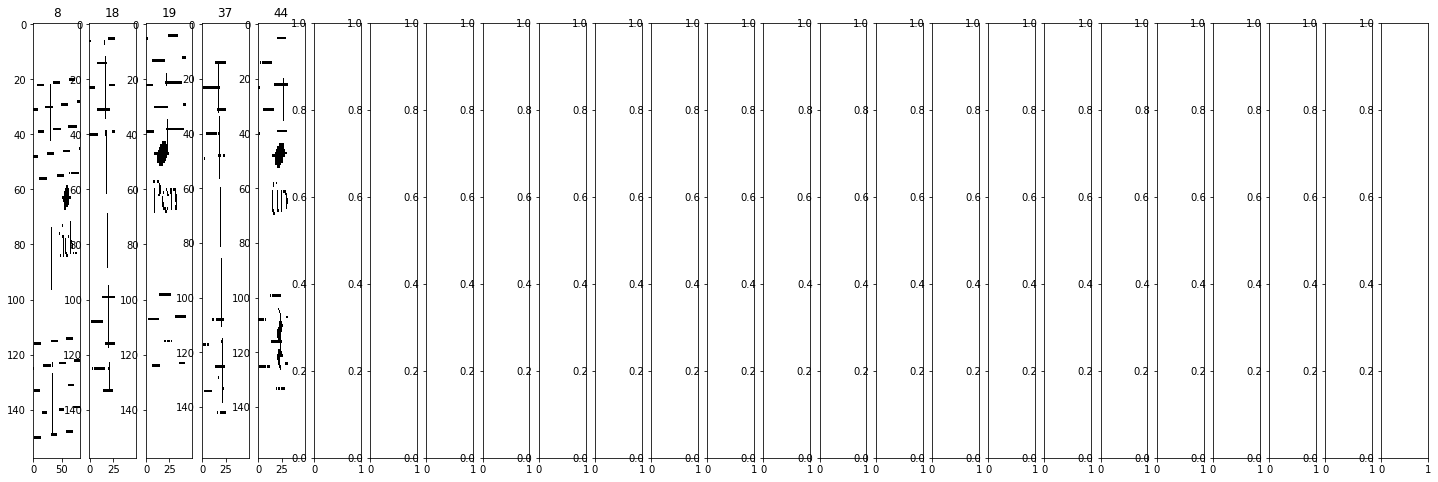

cluster:  4


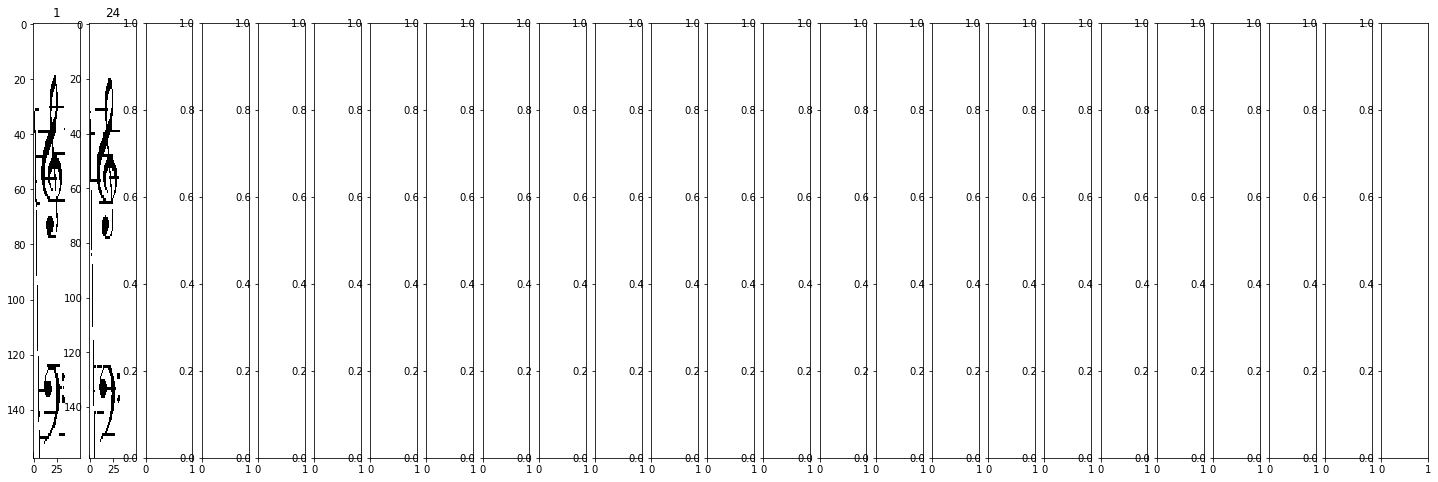

cluster:  5


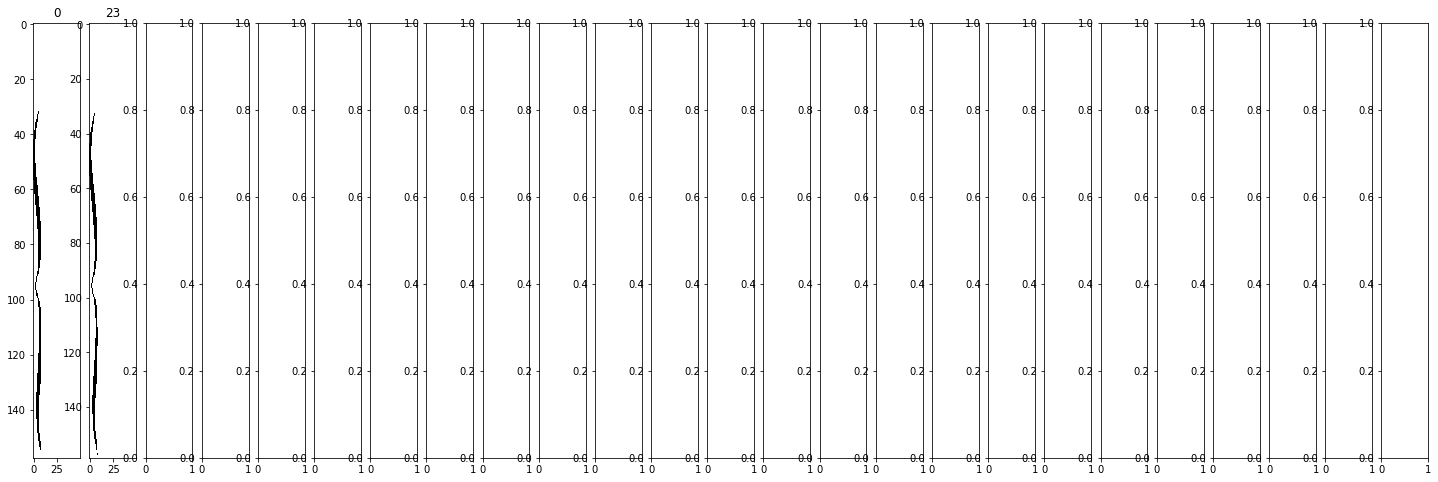

cluster:  6


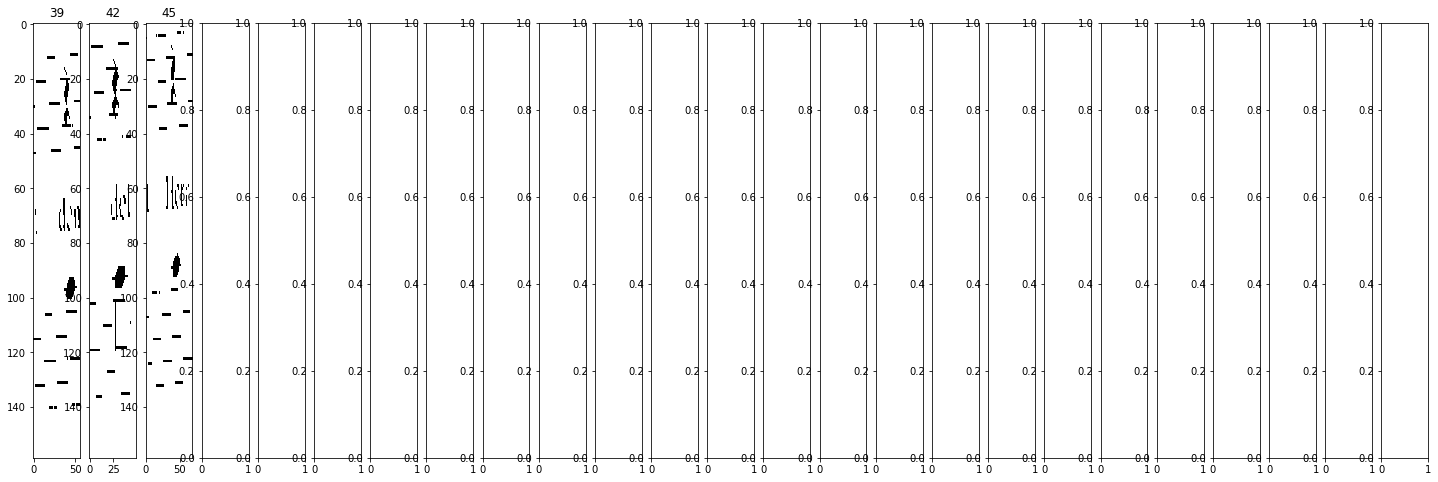

cluster:  7


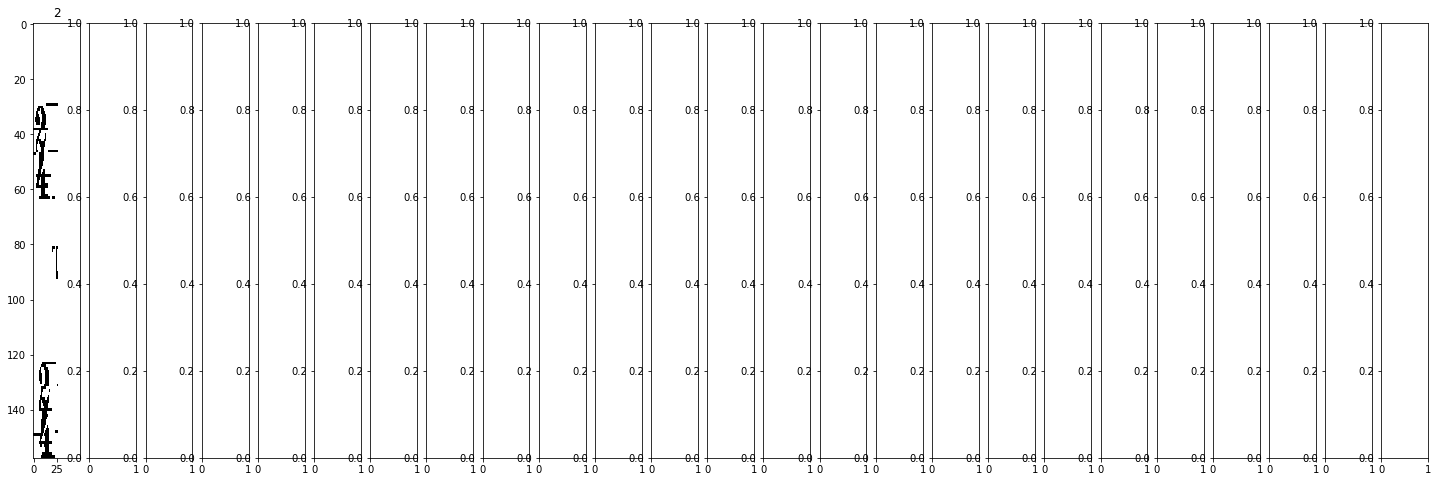

cluster:  8


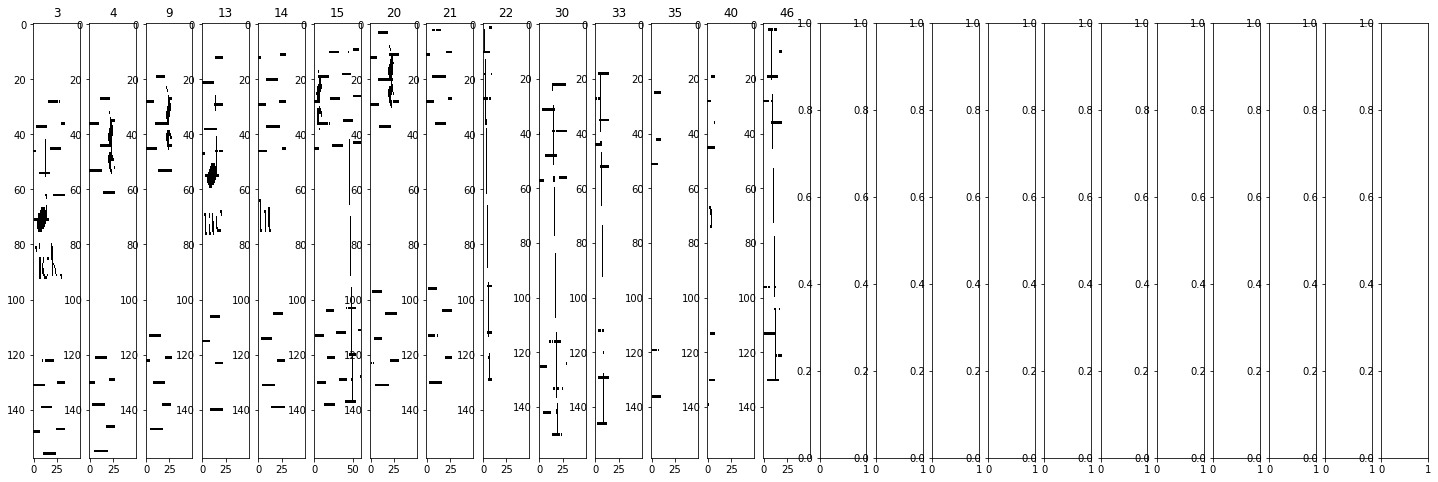

cluster:  9


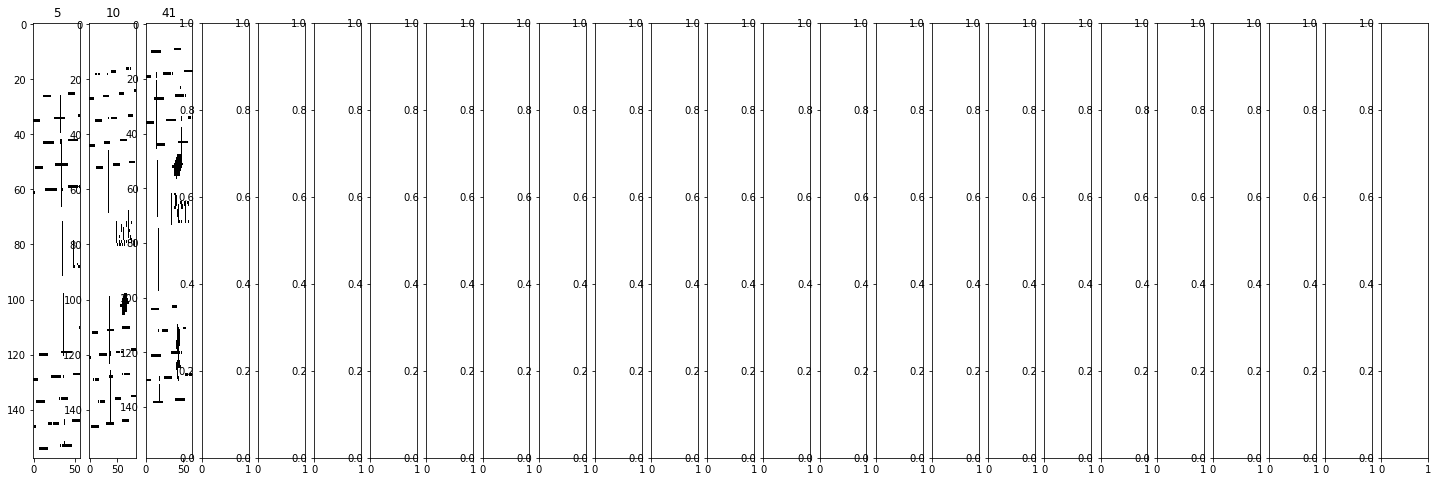

In [18]:
# display images per cluster

idx = [[] for i in range(num_cluster)]
for i in range (len (k.labels_)):
    c = k.labels_[i]
    idx[c].append (i)

for selected_cluster in range (num_cluster):
    print ("cluster: ", selected_cluster)
    fig, axs = plt.subplots(1, num_entries, figsize=(num_entries,8))
    for i in range (min(num_entries,len(idx[selected_cluster]))):
        clustered_img = idx[selected_cluster][i]
        axs[i].set_title (str(clustered_img))
        axs[i].imshow(crop_images[clustered_img], aspect='auto', cmap="gray")
    plt.show()

## cluster images by density

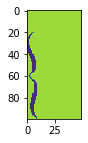

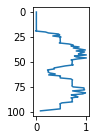

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.00374532 -0.01498127  0.18164794  0.24438202  0.44194757  0.46816479
  0.32958801  0.49157303  0.47378277  0.47752809  0.47752809  0.47752809
  0.48127341  0.46067416  0.65168539  0.73595506  0.6928839   0.85486891
  0.73876404  0.86235955  0.97940075  0.79775281  0.96535581  0.8829588
  0.8417603   0.99906367  0.76217228  0.79775281  1.          0.82303371
  0.69569288  0.72097378  0.71629213  0.71629213  0.71161049  0.73689139
  0.5758427   0.46722846  0.35486891  0.36048689  0.22378277  0.24250936
  0.23314607  0.26310861  0.37640449  0.24625468  0.48127341  0.47846442
  0.47659176  0.69101124  0.72284644  0.71535581  0.71629213  0.71629213
  0.71629213  0.71722846  0.71161049  0.73501873  0.95131086  0.95505618
  0.96441948  0.72565543  0.8576779   0.98220974  0.92790262  0.6994382
  0.

In [19]:
# resize images to work with clustering

img_width = 50
img_height = 100

image_list = []
for crop in crop_images:
    img = Image.fromarray (crop)
    img = img.resize ((img_width, img_height), Image.ANTIALIAS)
    image_list.append(np.array(img))

plt.figure(figsize = (1,2))
plt.imshow (image_list[0])
plt.show ()
    
# calculate densities

img_densities = []
for img in image_list:
    density_array = []
    for y in range (img_height):
        density = sum (255-img[y,:])
        density_array.append (density)

    #rescale density to value 0 - 1
    max_val = max (density_array)
    density_array = (density_array / max_val) 
    img_densities.append (density_array)

image_array = np.stack (img_densities)

plt.figure(figsize = (1,2))
plt.gca().invert_yaxis()
plt.plot (image_array[0], np.arange(image_array[0].size))
plt.show ()

print (image_array[0])
print (image_array.shape)


In [20]:
X = image_array

# option: with PCA reduced data
#X = PCA(n_components=2).fit_transform(X) 

# run clustering
#k = KMeans(n_clusters=num_cluster, n_init=10).fit (X)
k = AgglomerativeClustering(n_clusters=num_cluster).fit (X)
print (k.labels_)

[7 4 4 8 6 0 1 1 4 6 0 1 3 3 5 9 2 1 1 3 5 9 9 7 4 8 6 0 2 1 3 4 6 9 0 2 1
 1 3 5 9 0 2 1 3 5 9 0]


cluster:  0


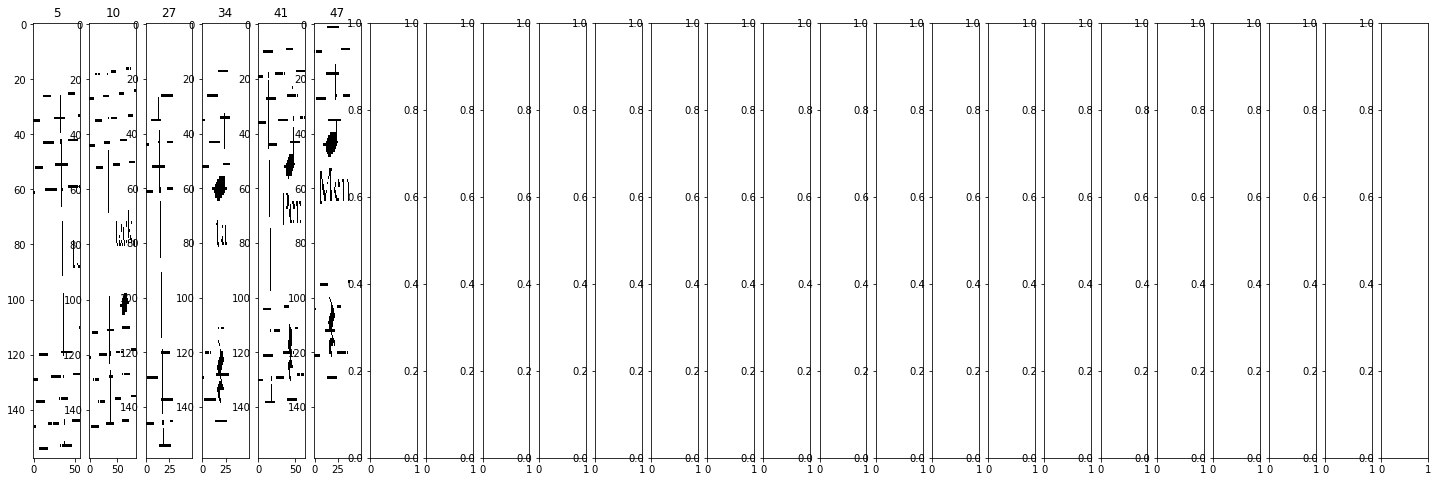

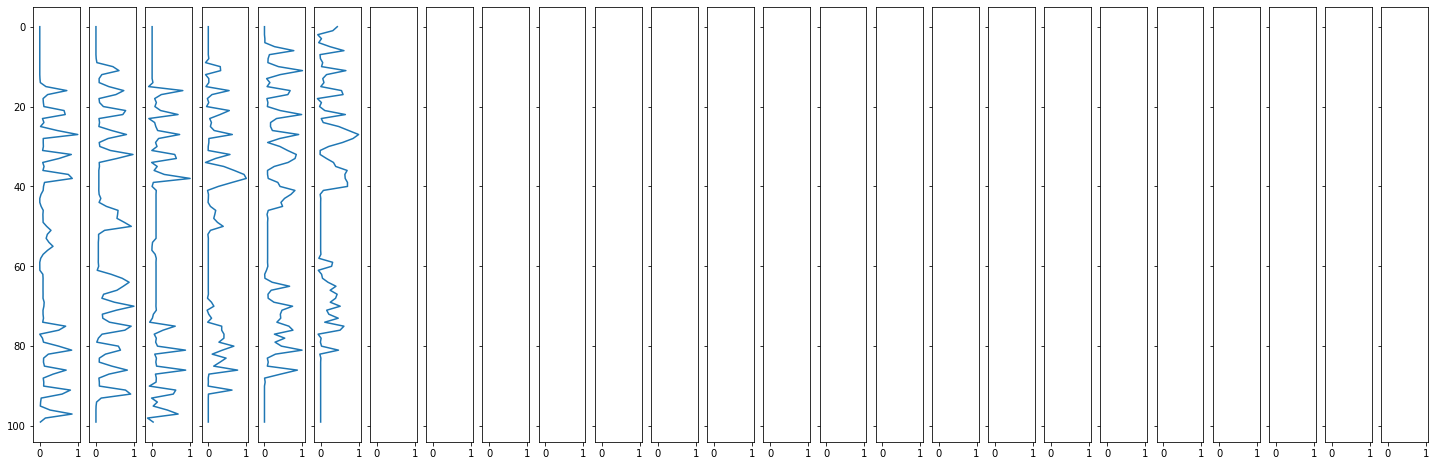

cluster:  1


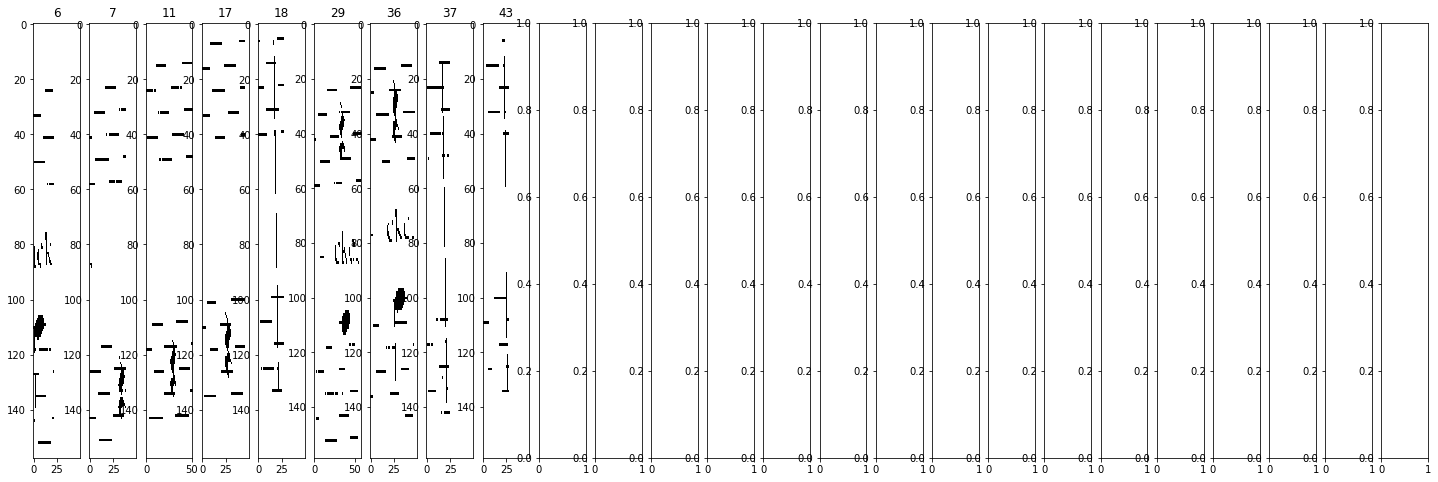

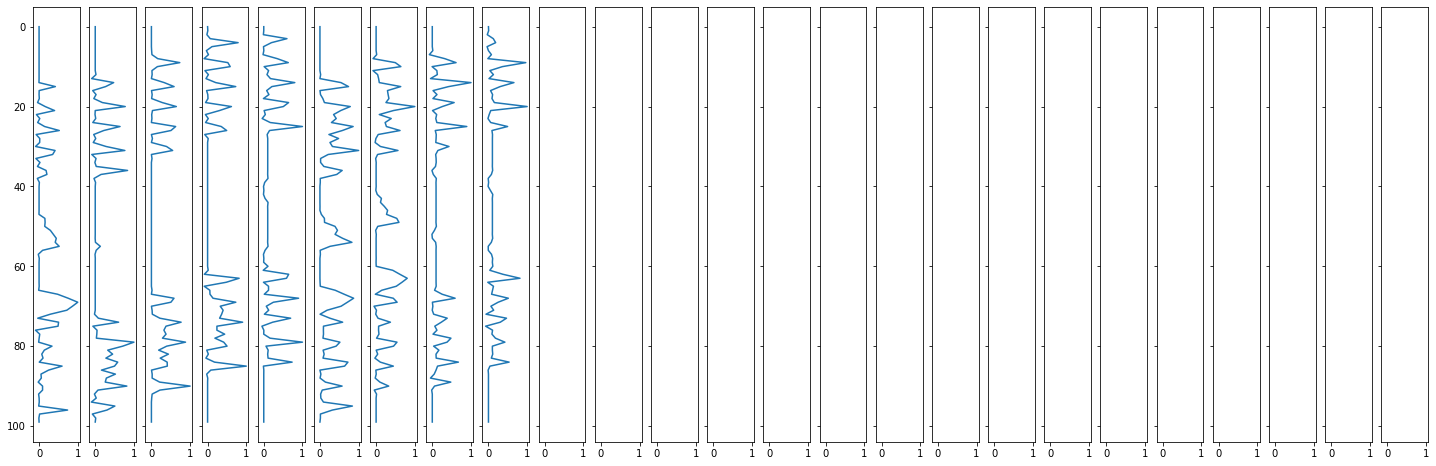

cluster:  2


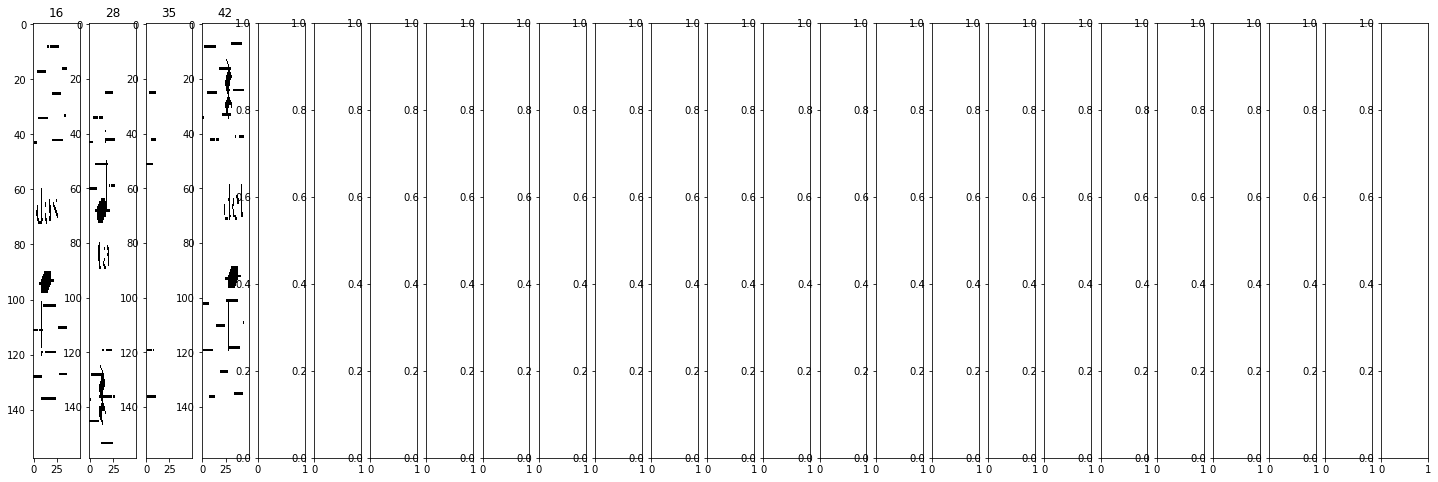

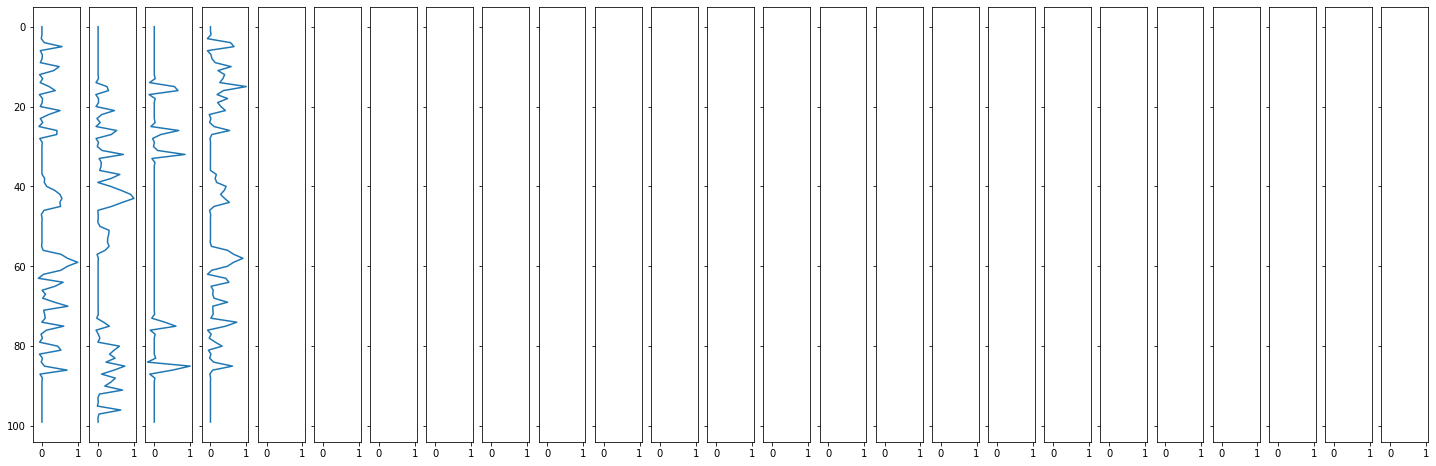

cluster:  3


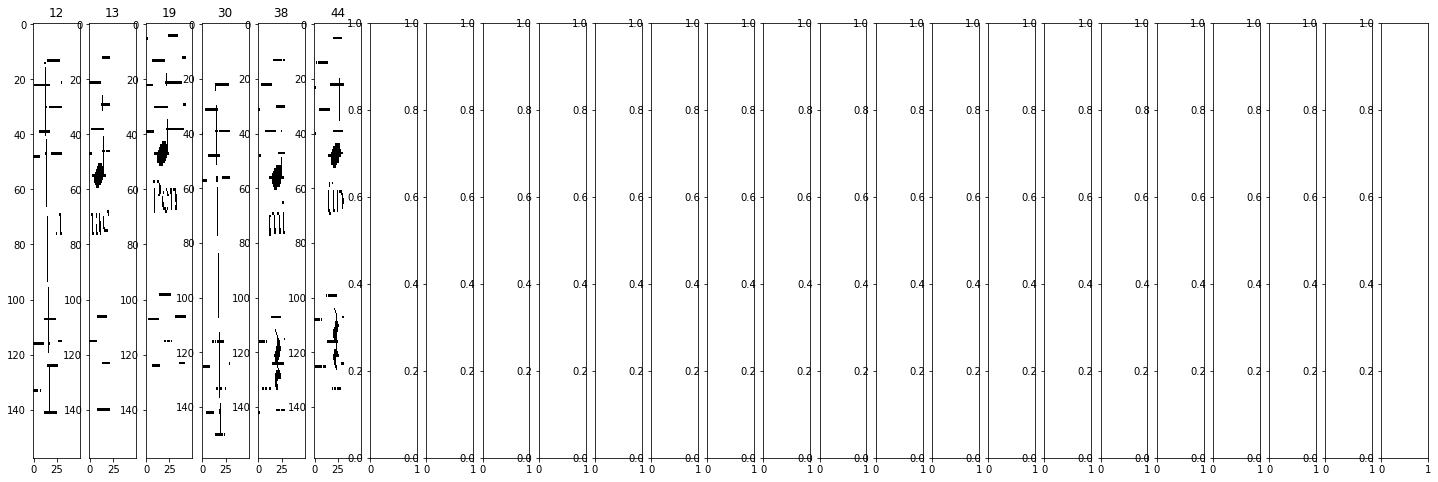

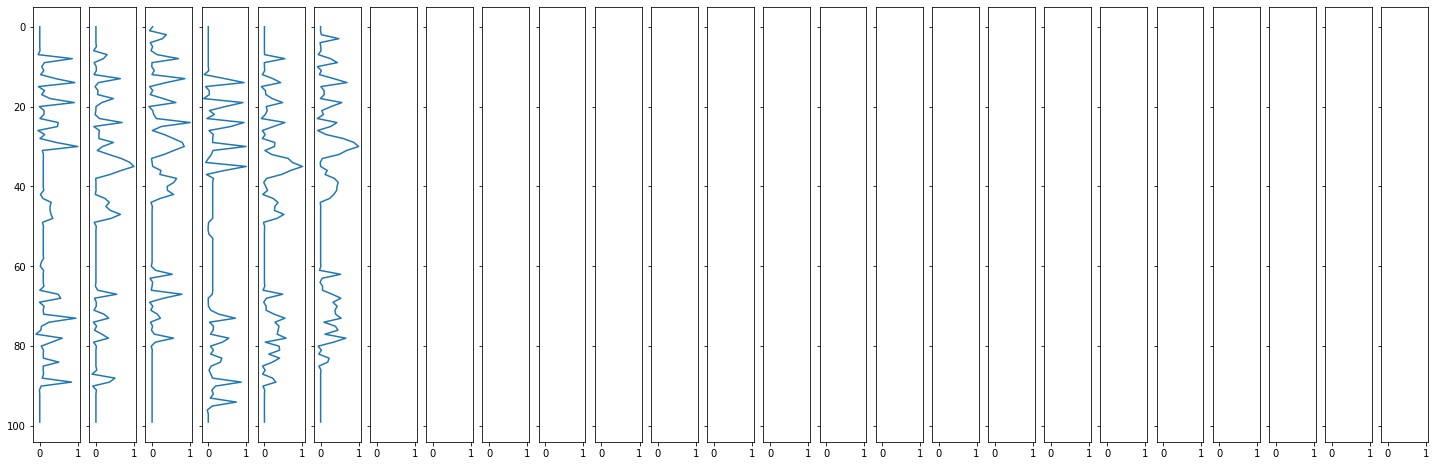

cluster:  4


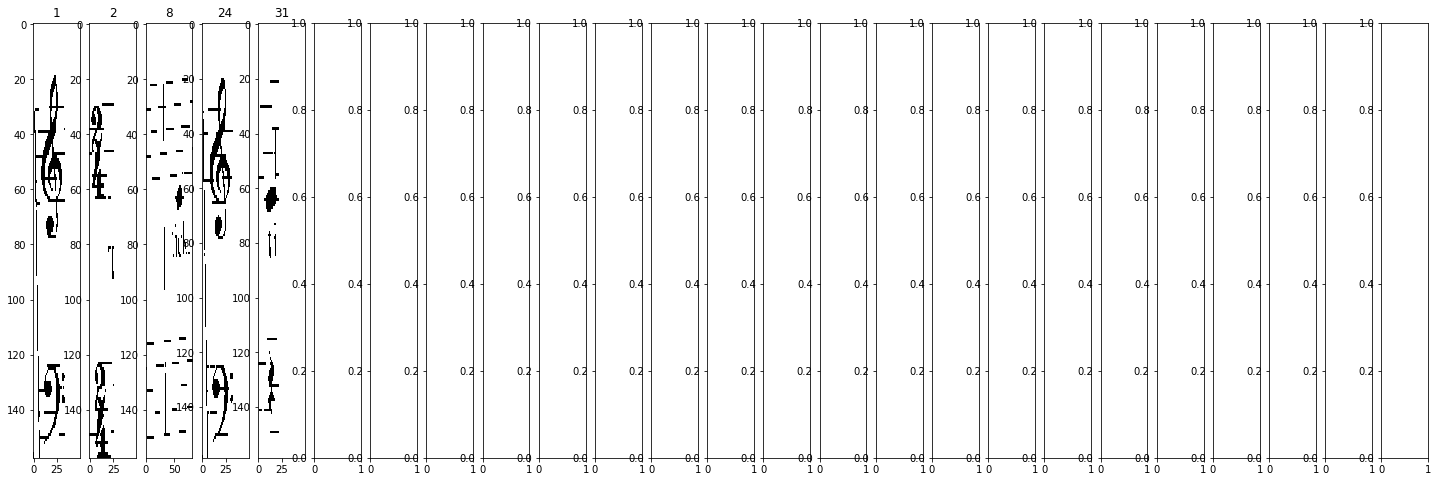

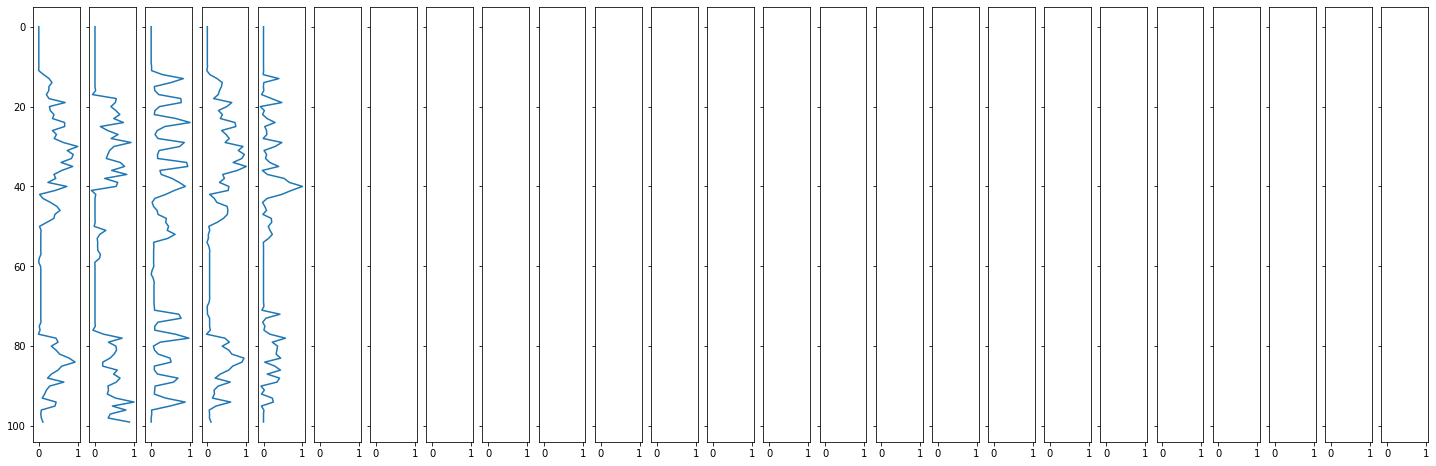

cluster:  5


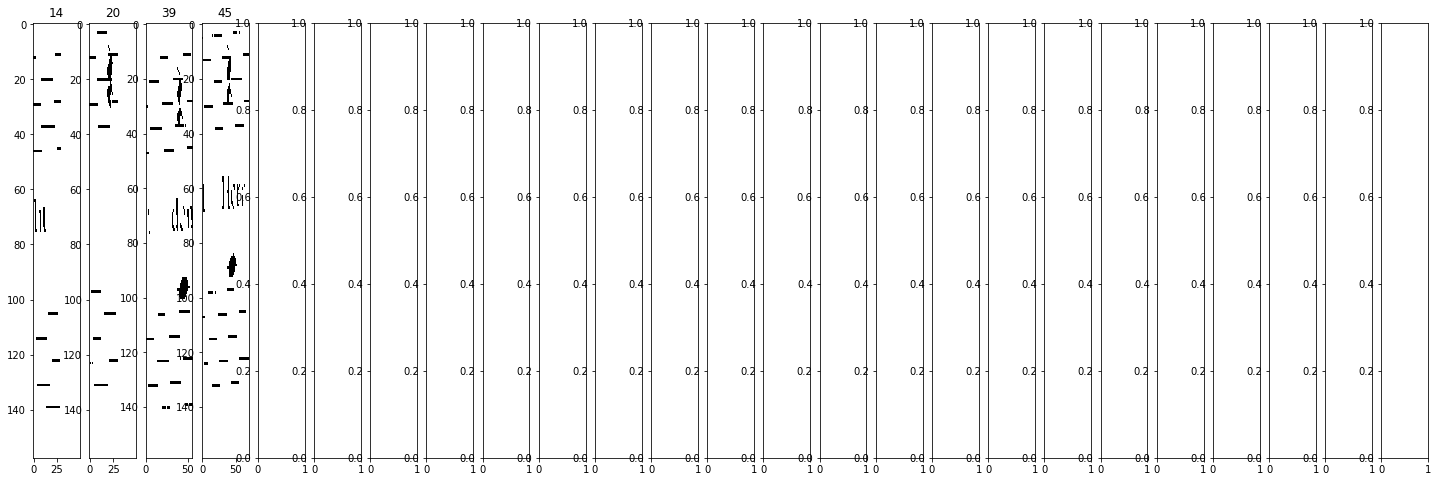

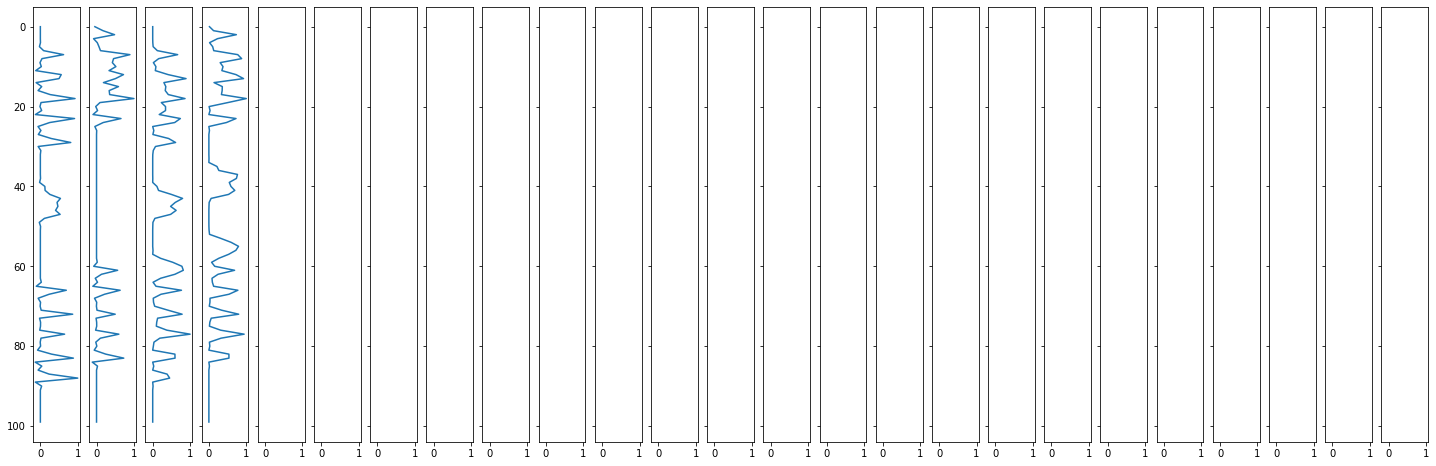

cluster:  6


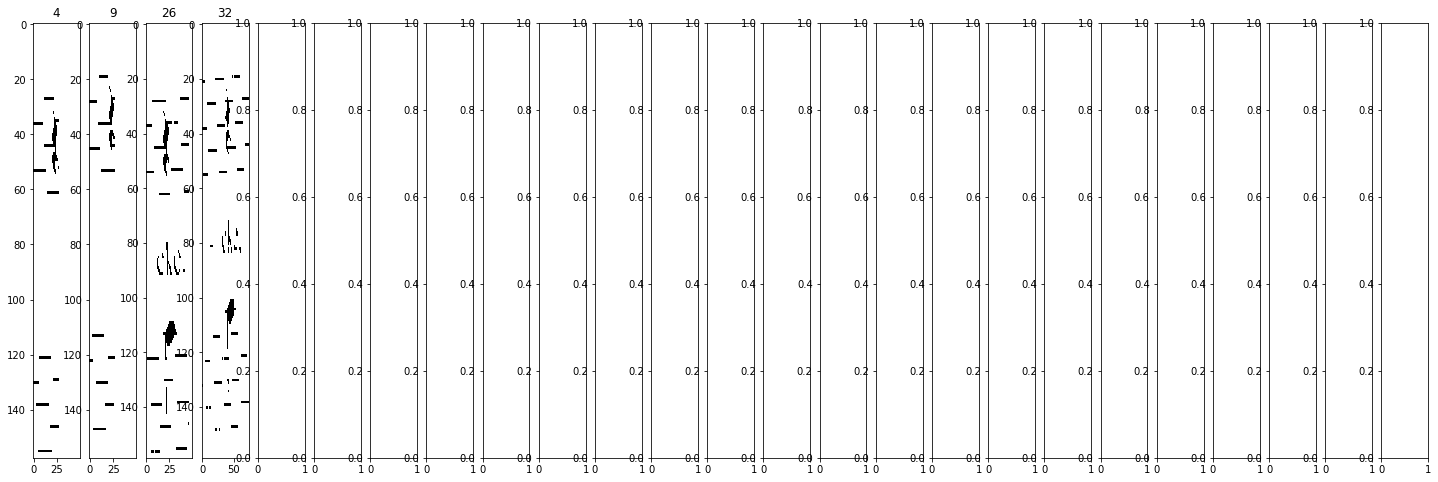

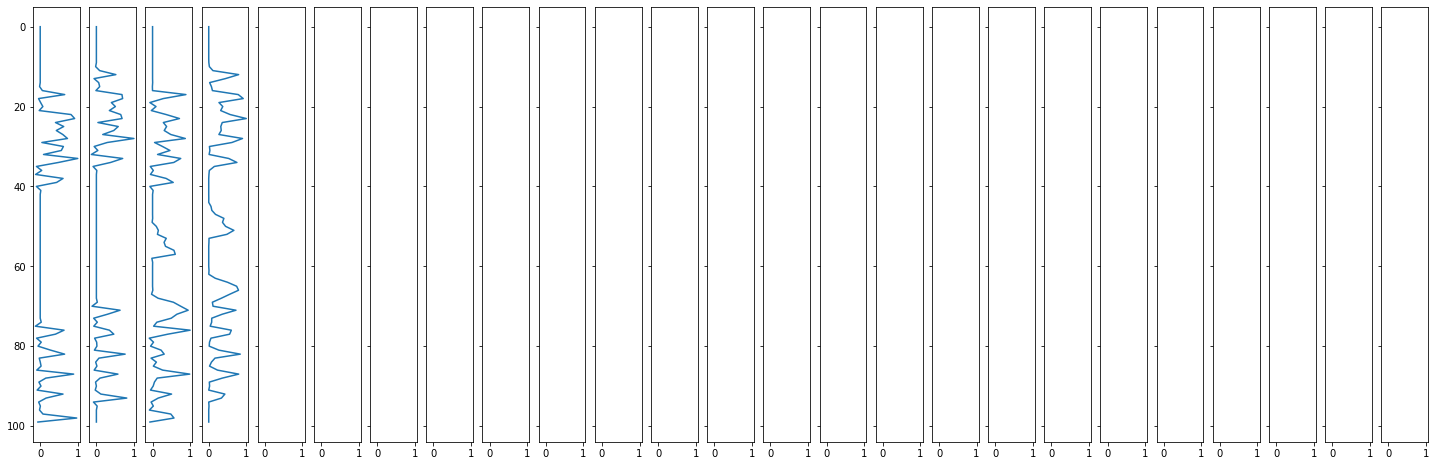

cluster:  7


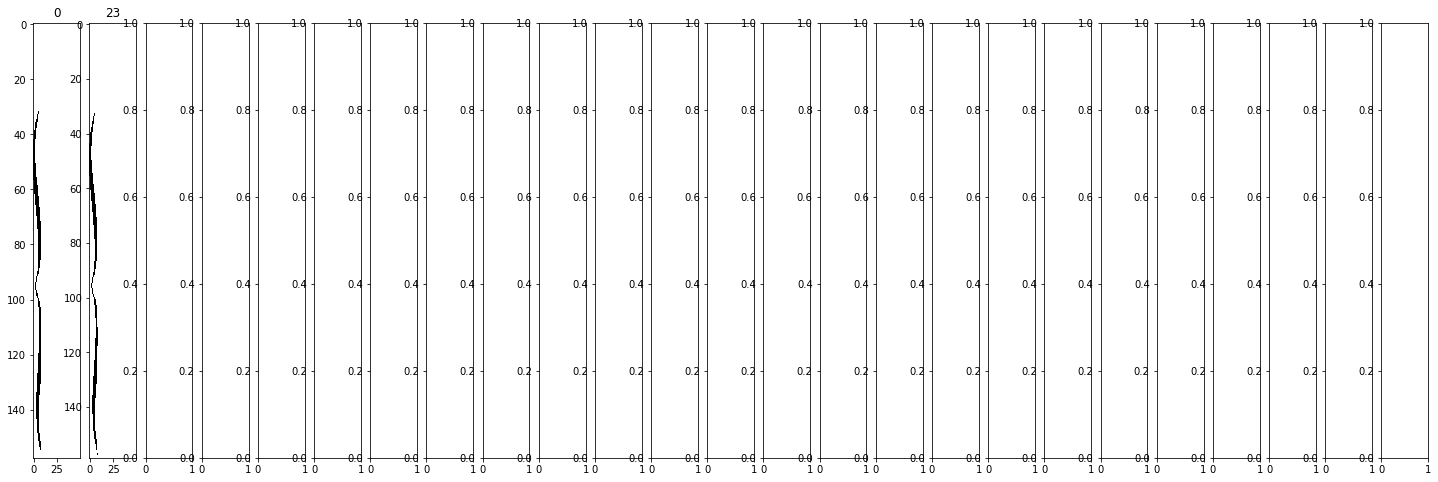

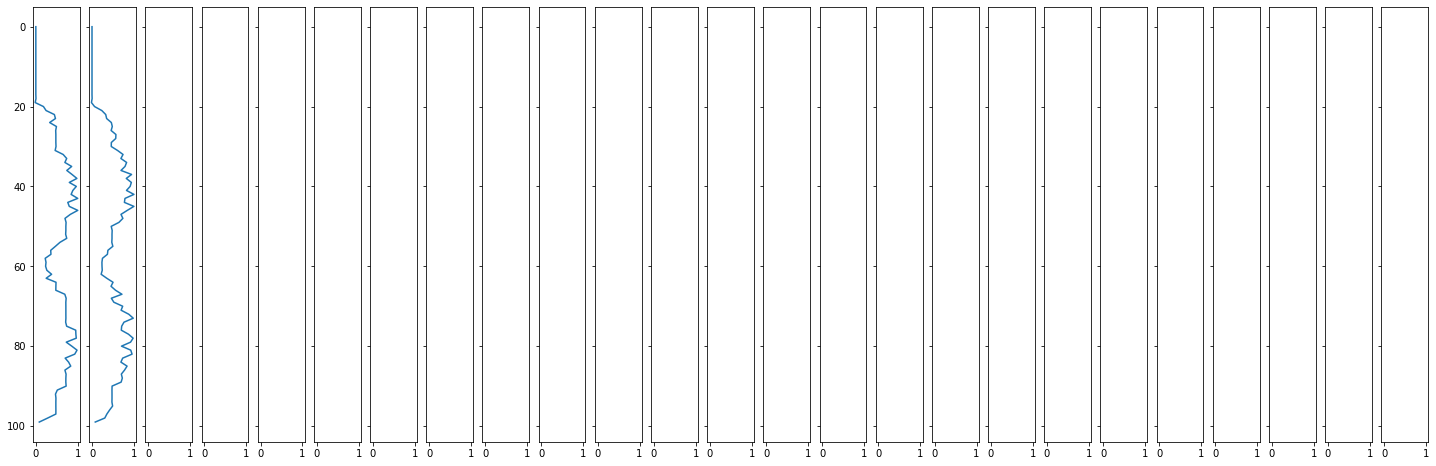

cluster:  8


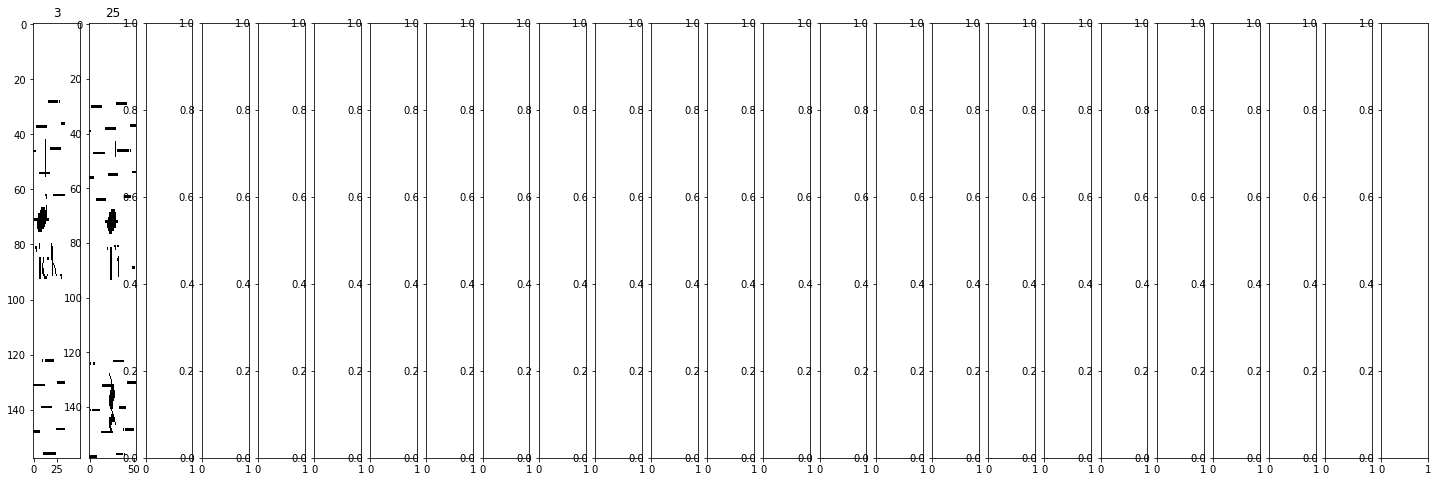

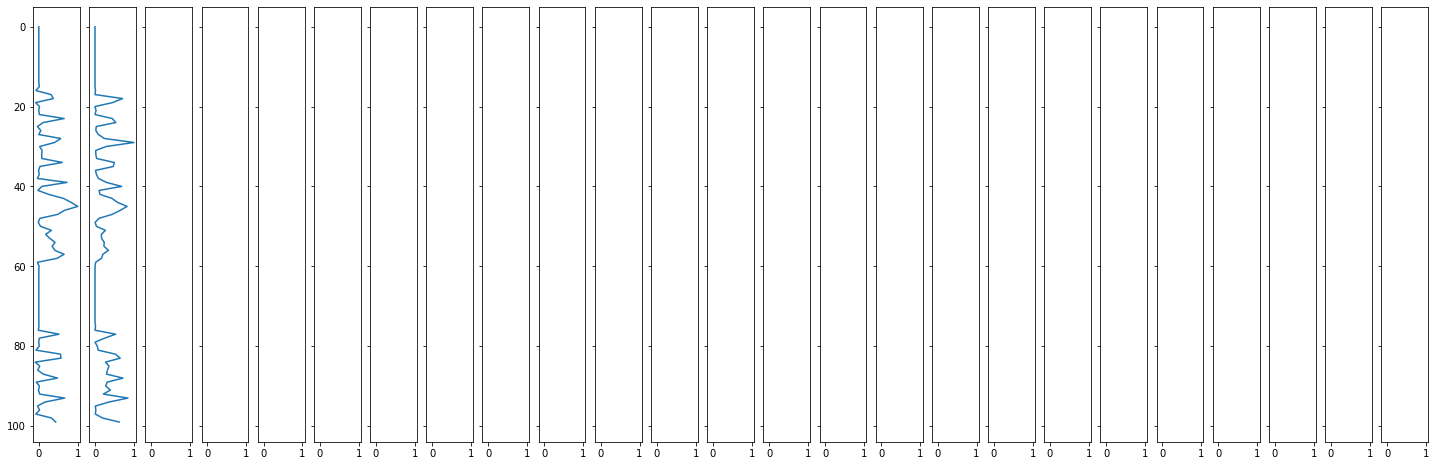

cluster:  9


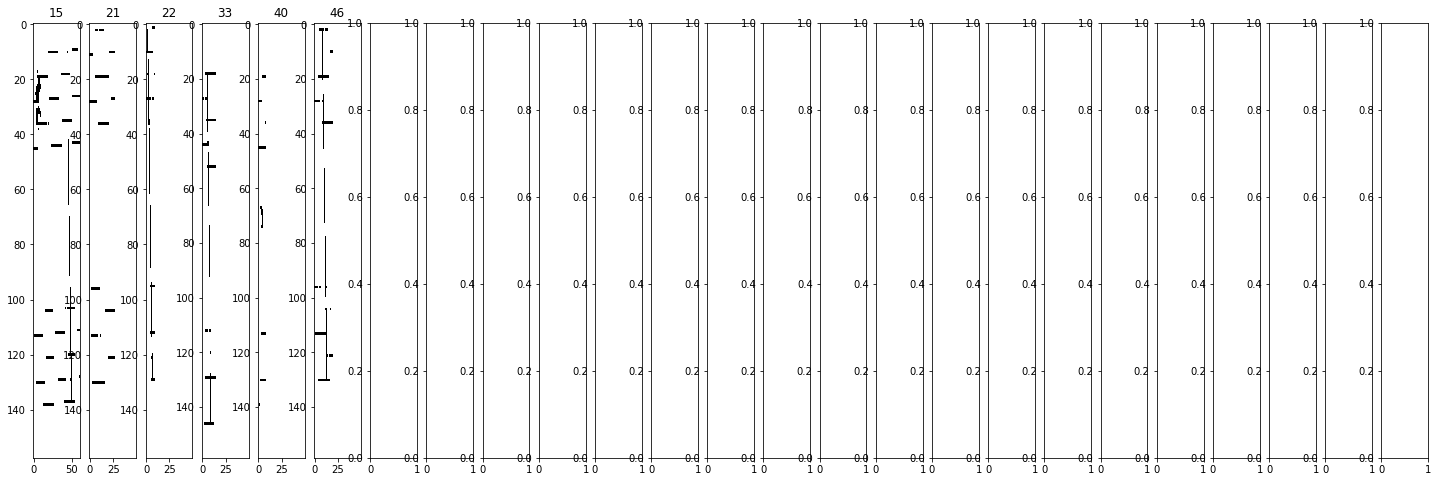

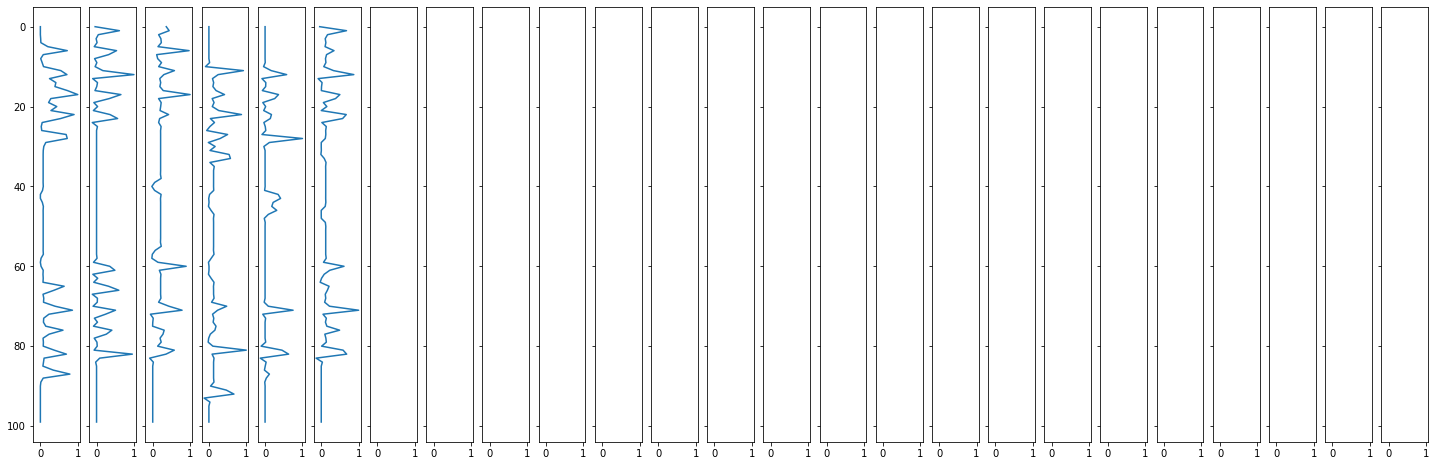

In [21]:
# display images per cluster

idx = [[] for i in range(num_cluster)]
for i in range (len (k.labels_)):
    c = k.labels_[i]
    idx[c].append (i)

for selected_cluster in range (num_cluster):
    print ("cluster: ", selected_cluster)

    # plot images
    fig, axs = plt.subplots(1, num_entries, figsize=(num_entries,8))
    for i in range (min(num_entries,len(idx[selected_cluster]))):
        clustered_img = idx[selected_cluster][i]
        axs[i].set_title (str(clustered_img))
        axs[i].imshow(crop_images[clustered_img], aspect='auto', cmap="gray")
    plt.show()

    # plot densities
    fig, axs = plt.subplots(1, num_entries, figsize=(num_entries,8), sharex=True, sharey=True)
    axs[0].invert_yaxis()
    for i in range (min(num_entries,len(idx[selected_cluster]))):
        clustered_img = idx[selected_cluster][i]
        axs[i].plot (image_array[clustered_img], np.arange(image_array[clustered_img].size))
    plt.show()    
    

## image clustering with neuronal nets
https://github.com/elcorto/imagecluster

In [34]:
# Create image database in memory. This helps to feed images to the NN model
# quickly.
ias = icio.read_images(fpath_notes, size=(224, 224))
#ias = np.asarray (crop_images)

# Create Keras NN model.
model = calc.get_model()

# Feed images through the model and extract fingerprints (feature vectors).
fps = calc.fingerprints(ias, model)

# Optionally run a PCA on the fingerprints to compress the dimensions. Use a
# cumulative explained variance ratio of 0.95.
#fps = calc.pca(fps, n_components=0.95)

# Run clustering on the fingerprints.  Select clusters with similarity index
# sim=0.5
clusters = calc.cluster(fps, sim=0.6)

# Create dirs with links to images. Dirs represent the clusters the images
# belong to.
#pp.make_links(clusters, 'pics/imagecluster/clusters')

# Plot images arranged in clusters.
#pp.visualize(clusters, ias)



C:\Data\Dev-Data\music\notes\01_0_0.PNG
C:\Data\Dev-Data\music\notes\01_0_1.PNG
C:\Data\Dev-Data\music\notes\01_0_10.PNG
C:\Data\Dev-Data\music\notes\01_0_11.PNG
C:\Data\Dev-Data\music\notes\01_0_12.PNG
C:\Data\Dev-Data\music\notes\01_0_13.PNG
C:\Data\Dev-Data\music\notes\01_0_14.PNG
C:\Data\Dev-Data\music\notes\01_0_15.PNG
C:\Data\Dev-Data\music\notes\01_0_16.PNG
C:\Data\Dev-Data\music\notes\01_0_17.PNG
C:\Data\Dev-Data\music\notes\01_0_18.PNG
C:\Data\Dev-Data\music\notes\01_0_19.PNG
C:\Data\Dev-Data\music\notes\01_0_2.PNG
C:\Data\Dev-Data\music\notes\01_0_20.PNG
C:\Data\Dev-Data\music\notes\01_0_21.PNG
C:\Data\Dev-Data\music\notes\01_0_22.PNG
C:\Data\Dev-Data\music\notes\01_0_23.PNG
C:\Data\Dev-Data\music\notes\01_0_24.PNG
C:\Data\Dev-Data\music\notes\01_0_25.PNG
C:\Data\Dev-Data\music\notes\01_0_3.PNG
C:\Data\Dev-Data\music\notes\01_0_4.PNG
C:\Data\Dev-Data\music\notes\01_0_5.PNG
C:\Data\Dev-Data\music\notes\01_0_6.PNG
C:\Data\Dev-Data\music\notes\01_0_7.PNG
C:\Data\Dev-Data\music

Cluster:  0


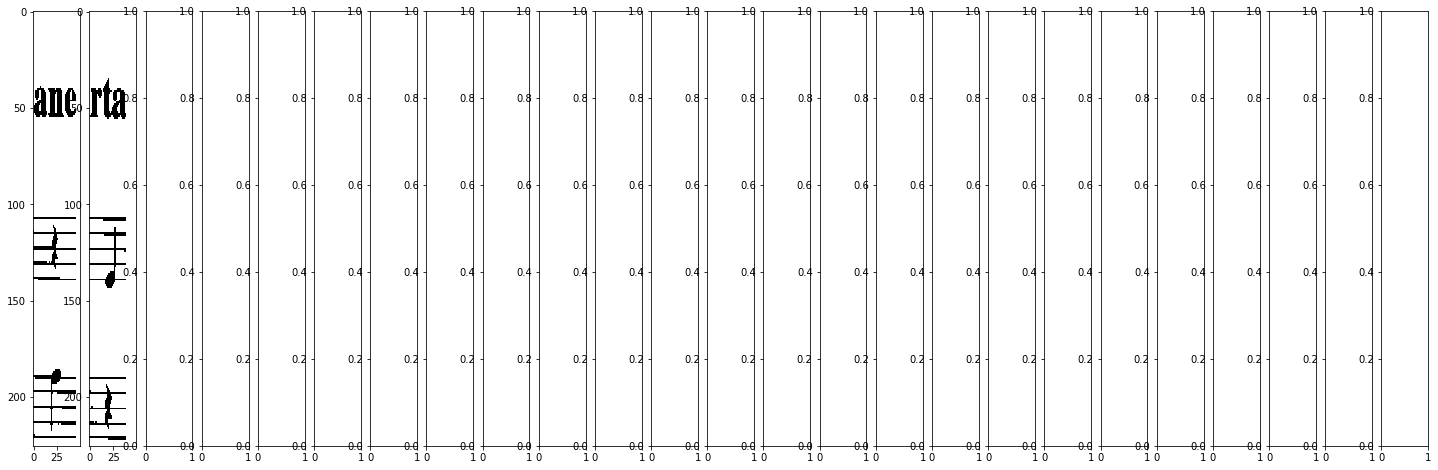

Cluster:  1


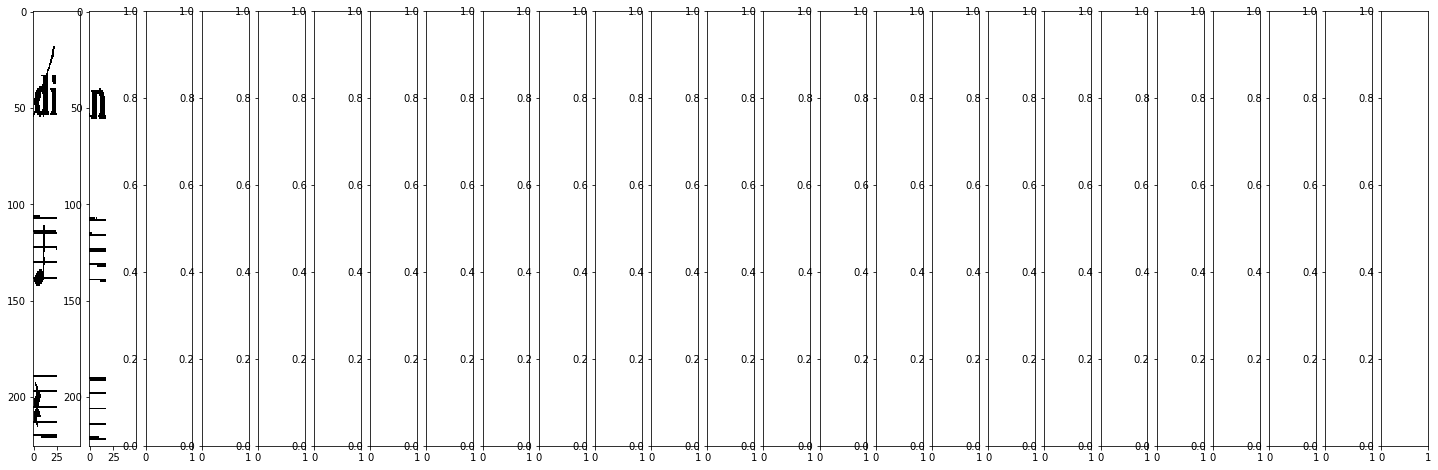

Cluster:  2


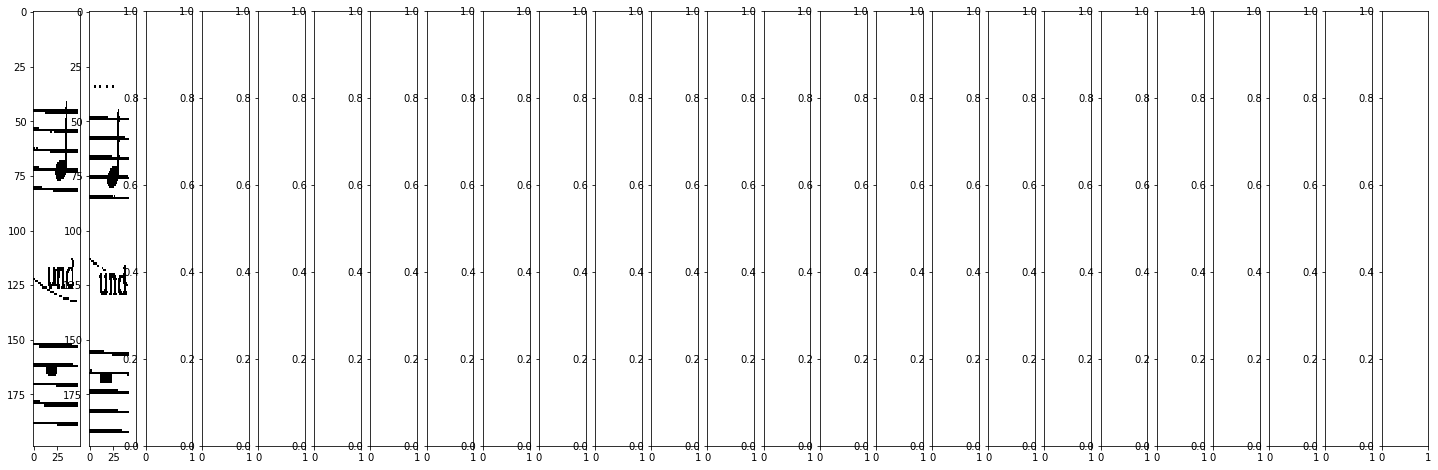

Cluster:  3


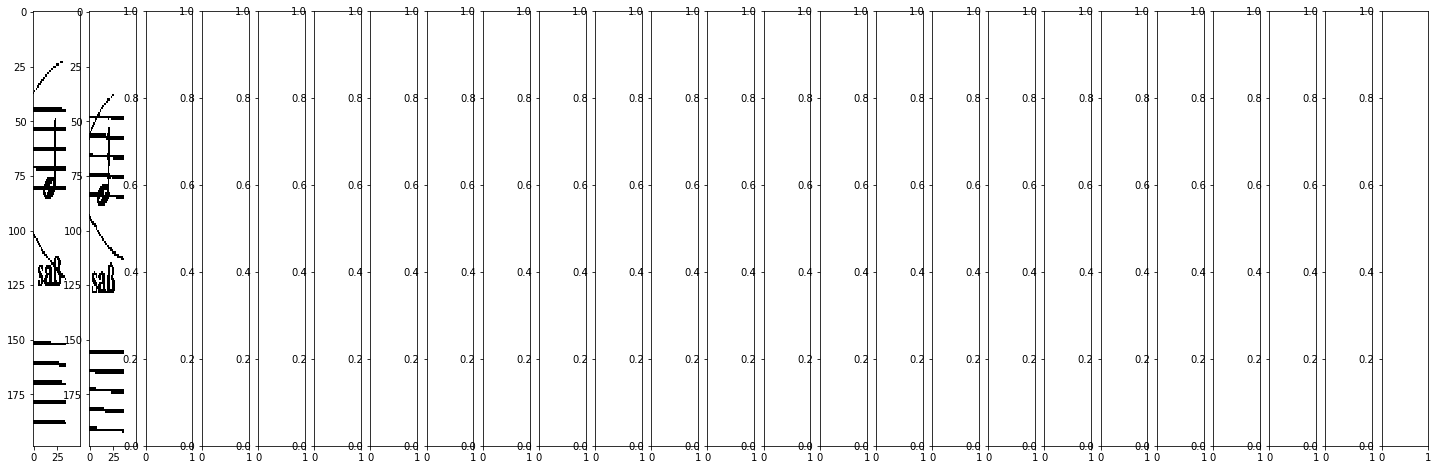

Cluster:  4


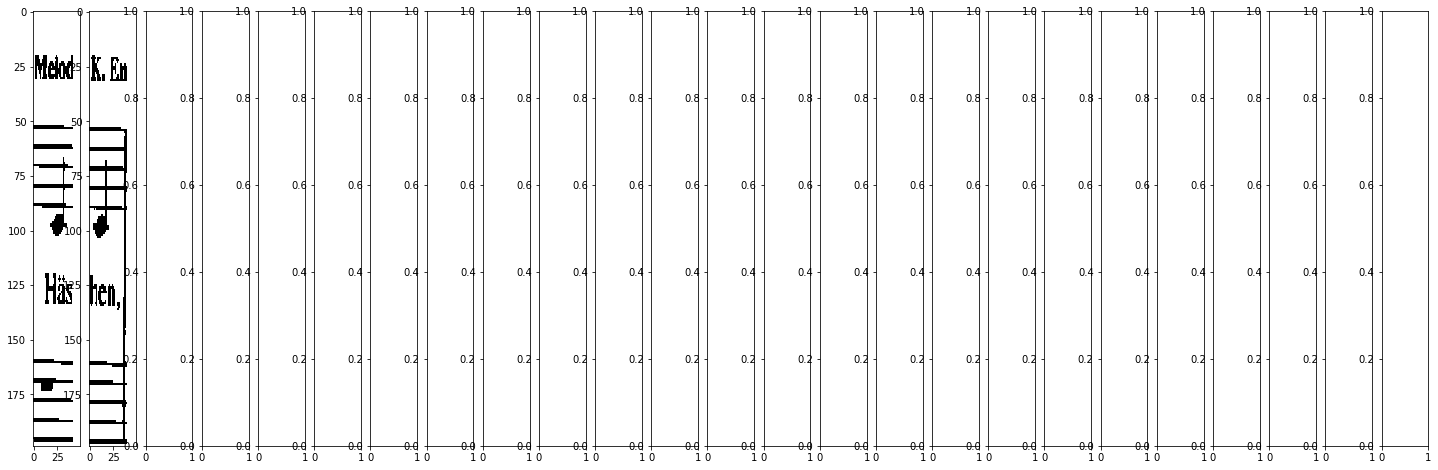

Cluster:  5


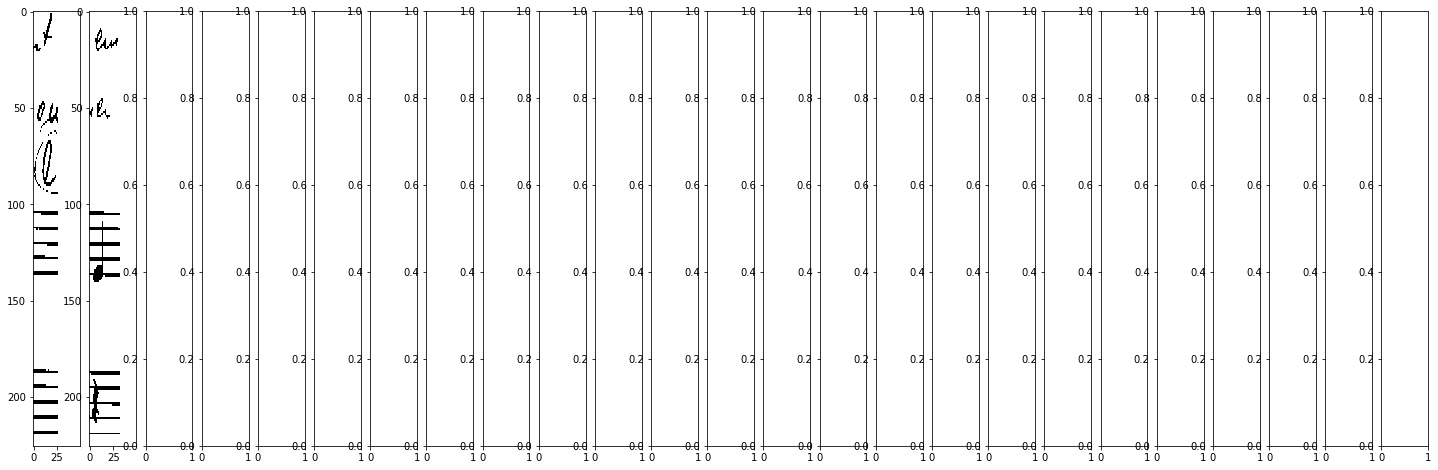

Cluster:  6


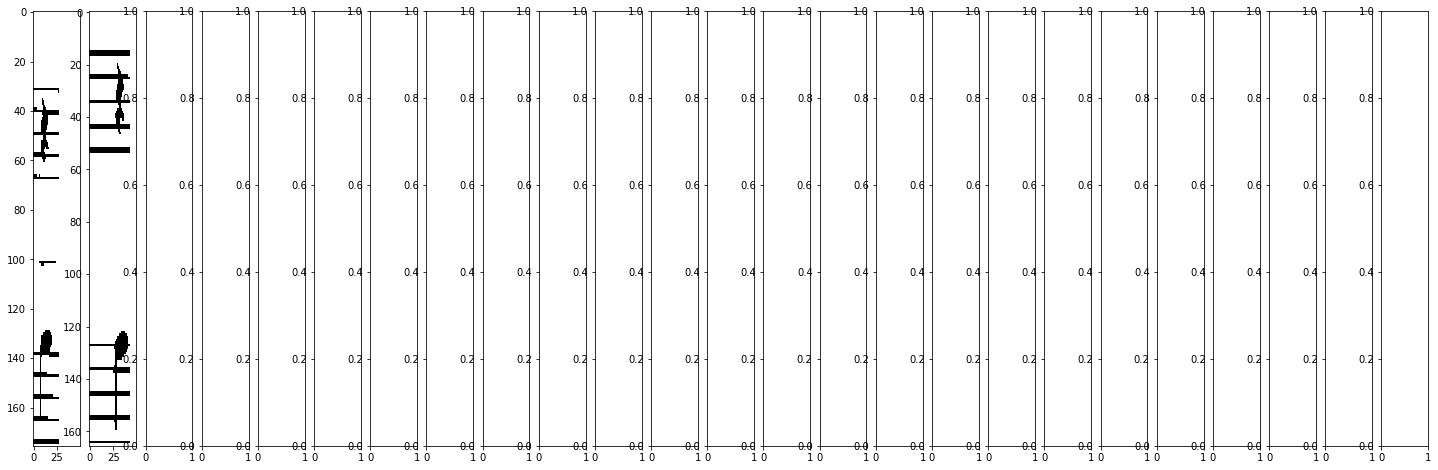

Cluster:  7


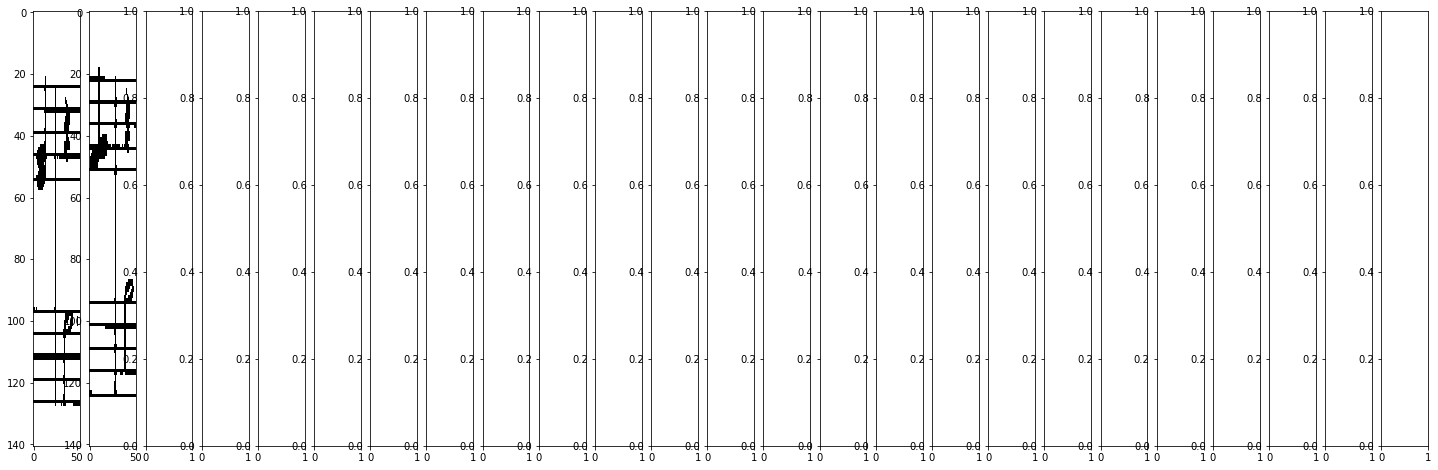

Cluster:  8


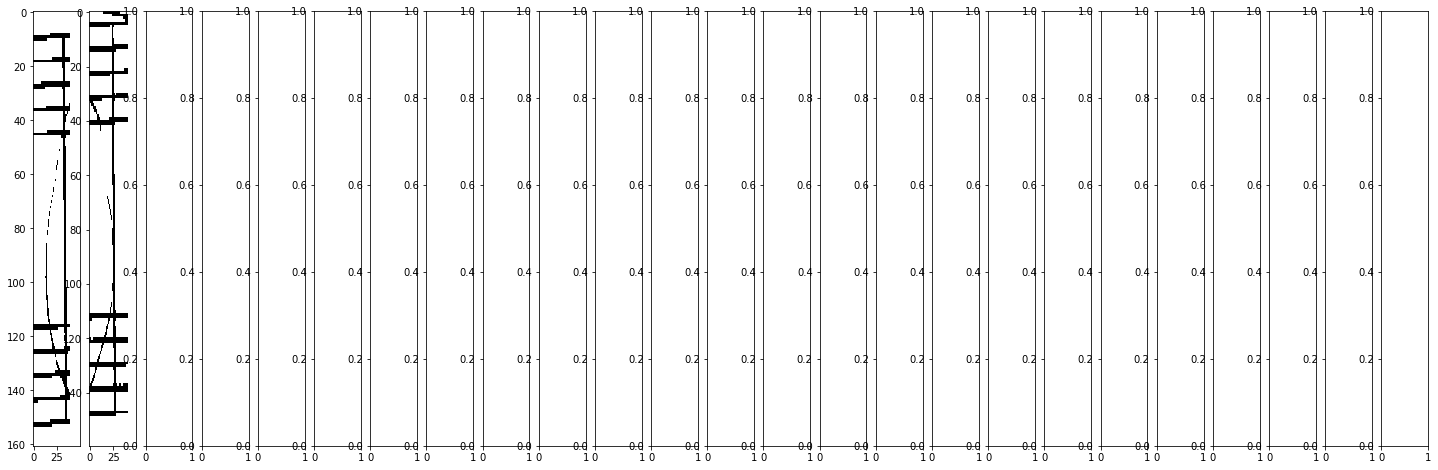

Cluster:  9


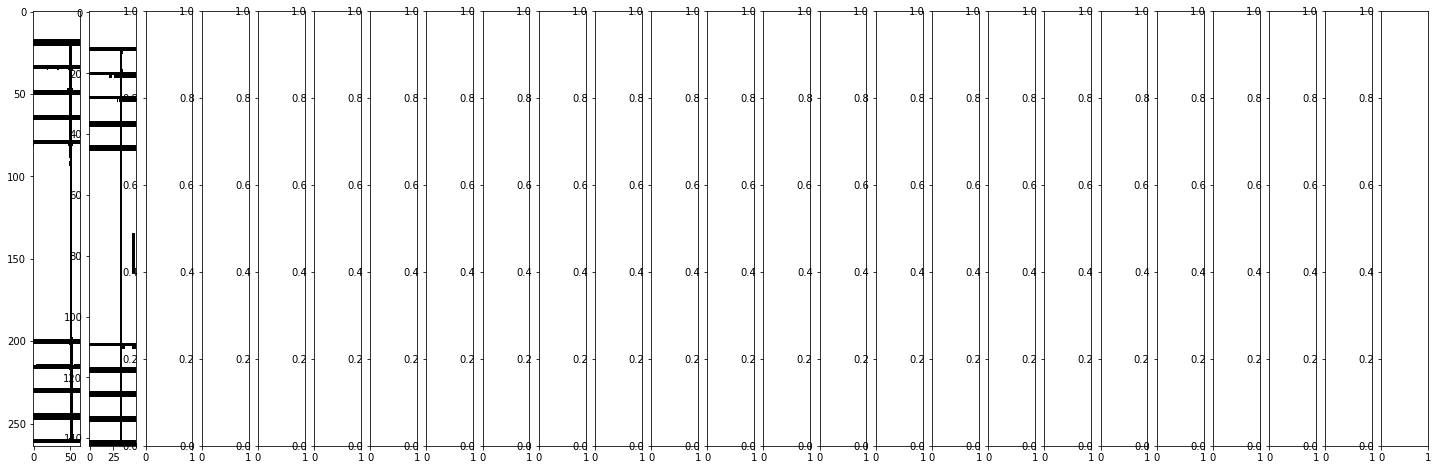

Cluster:  10


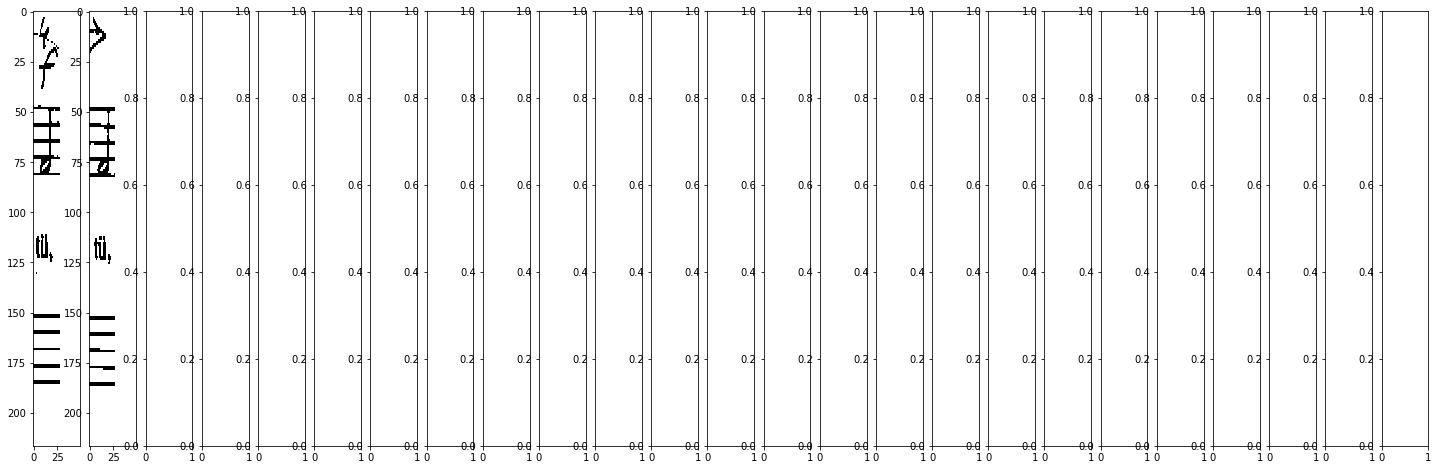

Cluster:  11


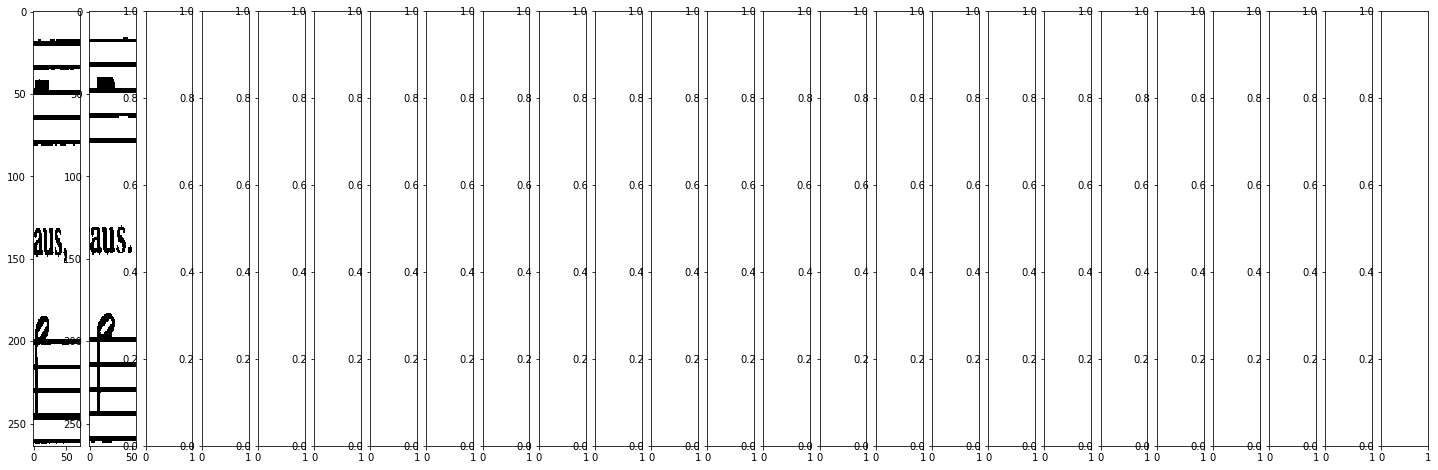

Cluster:  12


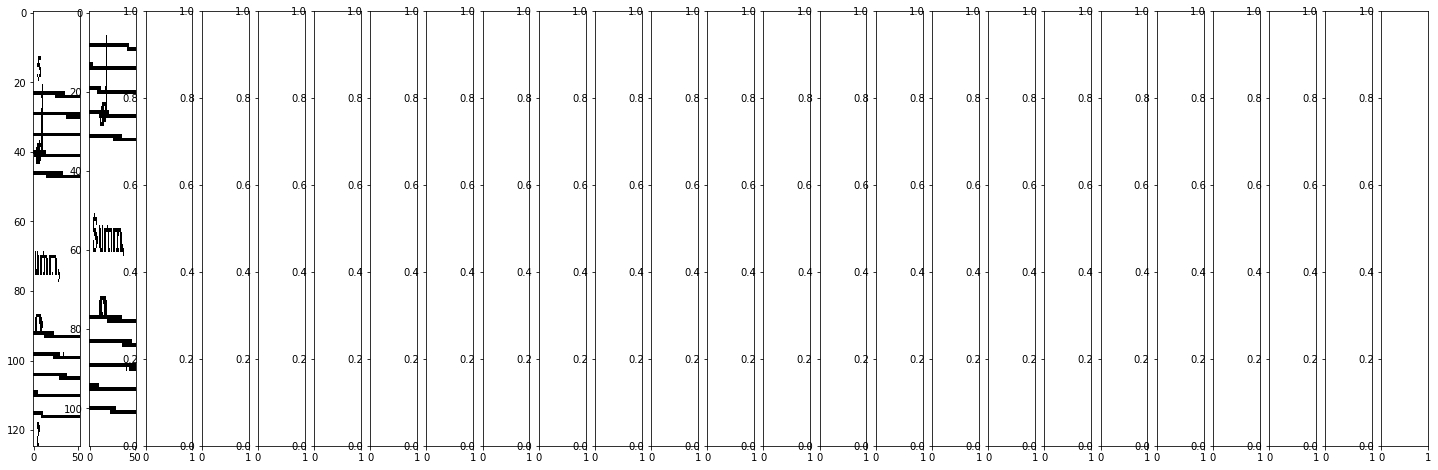

Cluster:  13


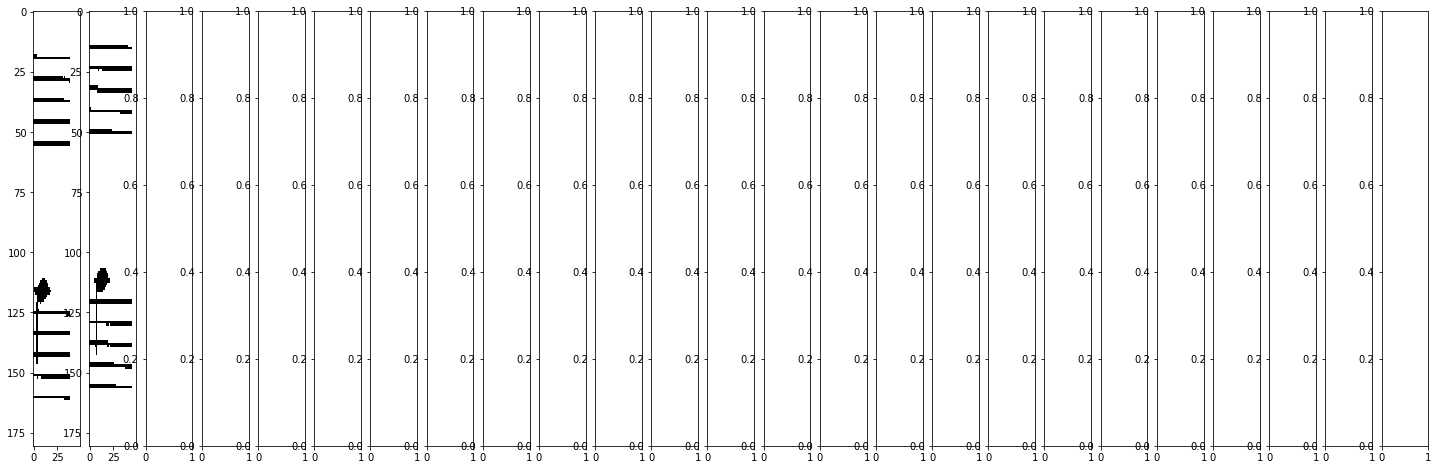

Cluster:  14


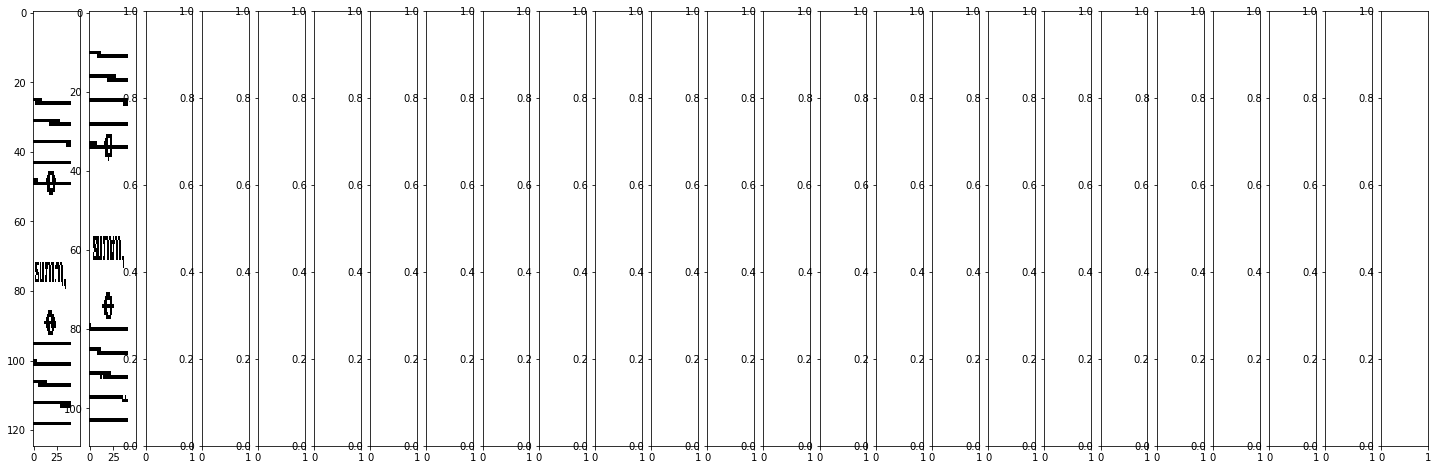

Cluster:  15


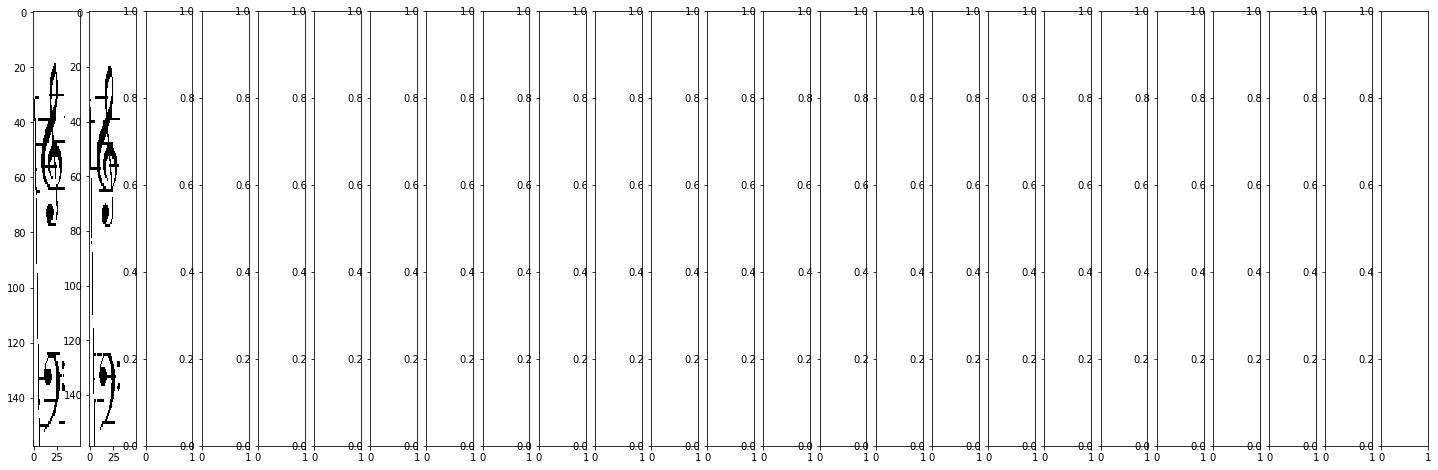

Cluster:  16


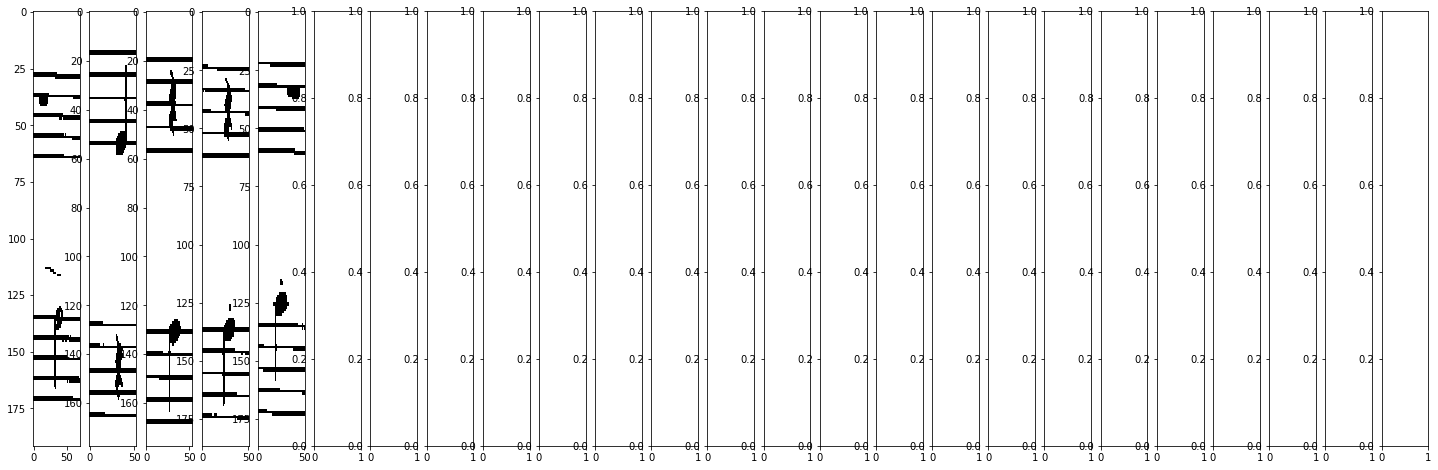

Cluster:  17


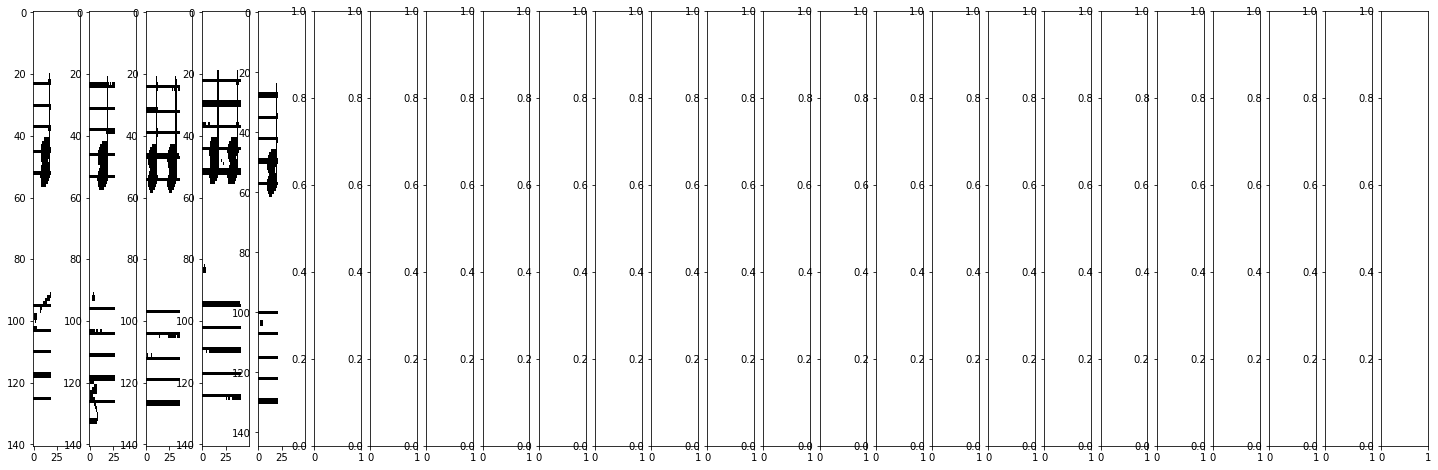

Cluster:  18


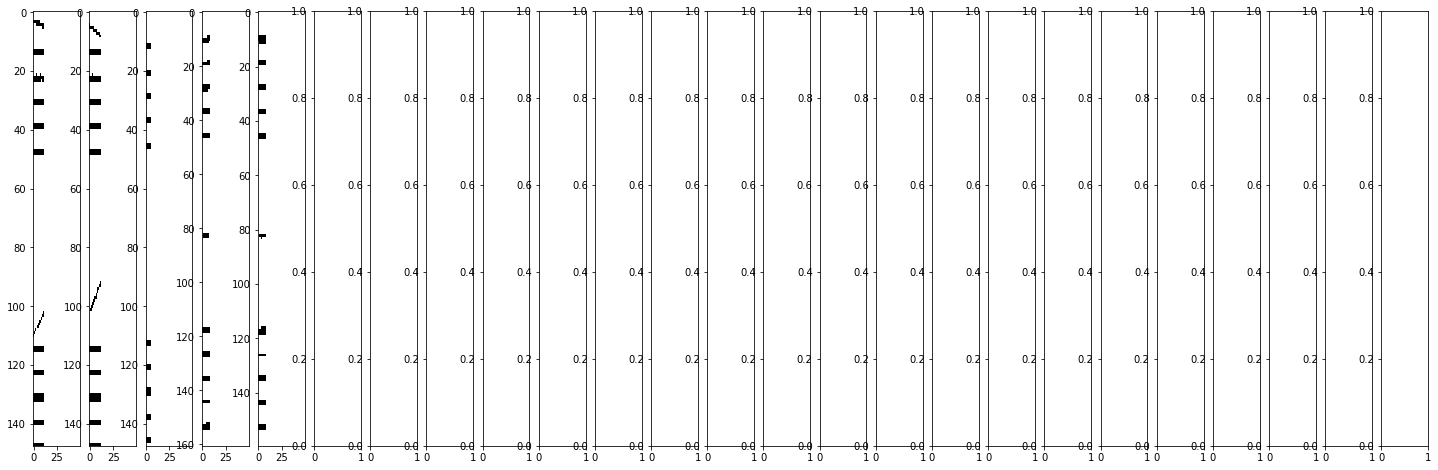

Cluster:  19


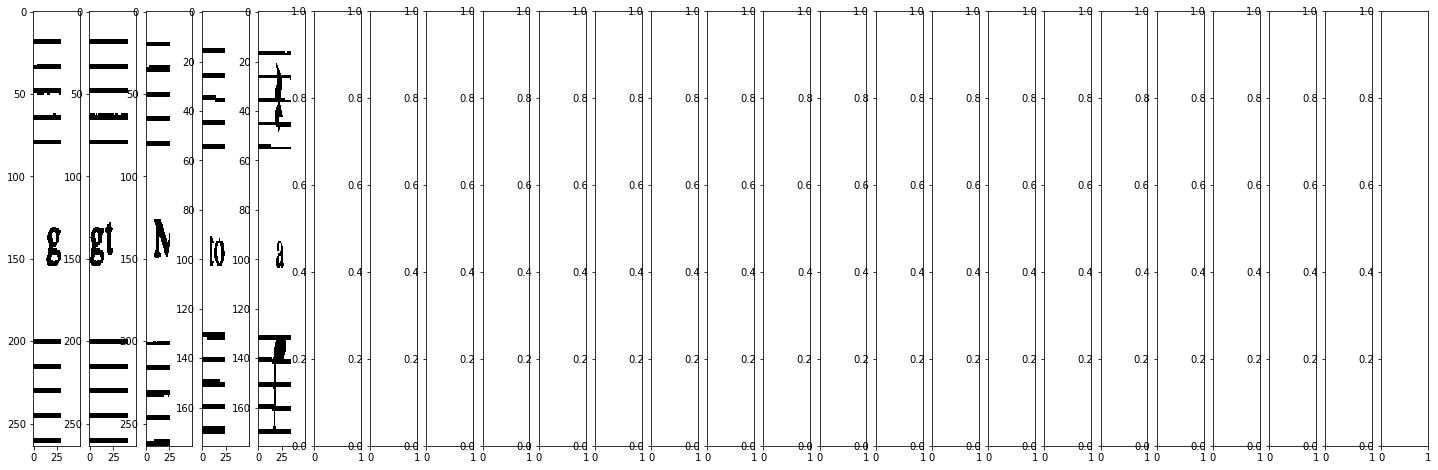

Cluster:  20


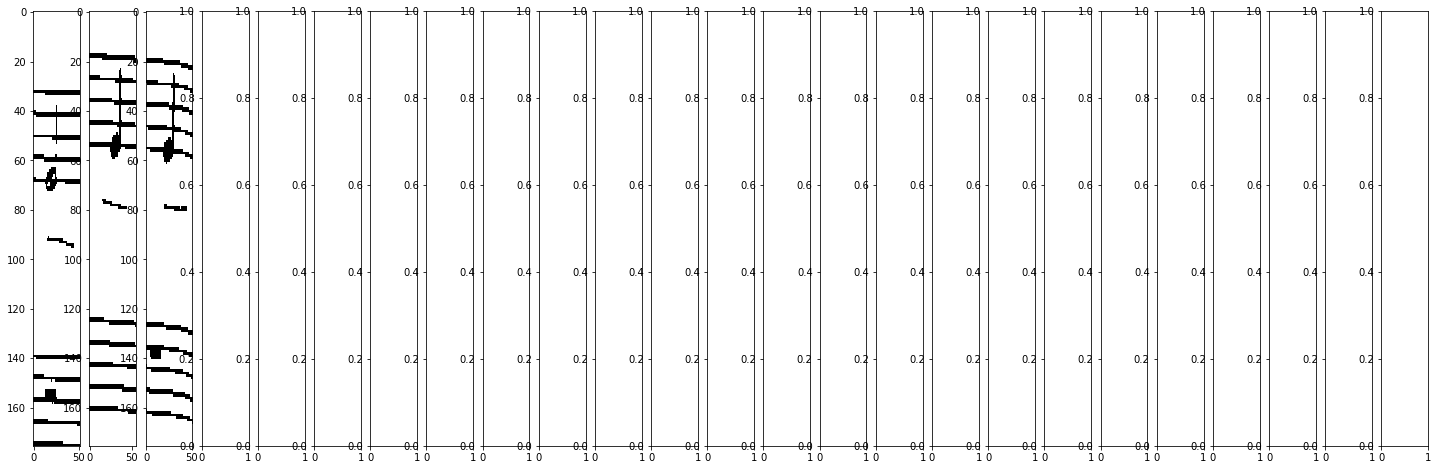

Cluster:  21


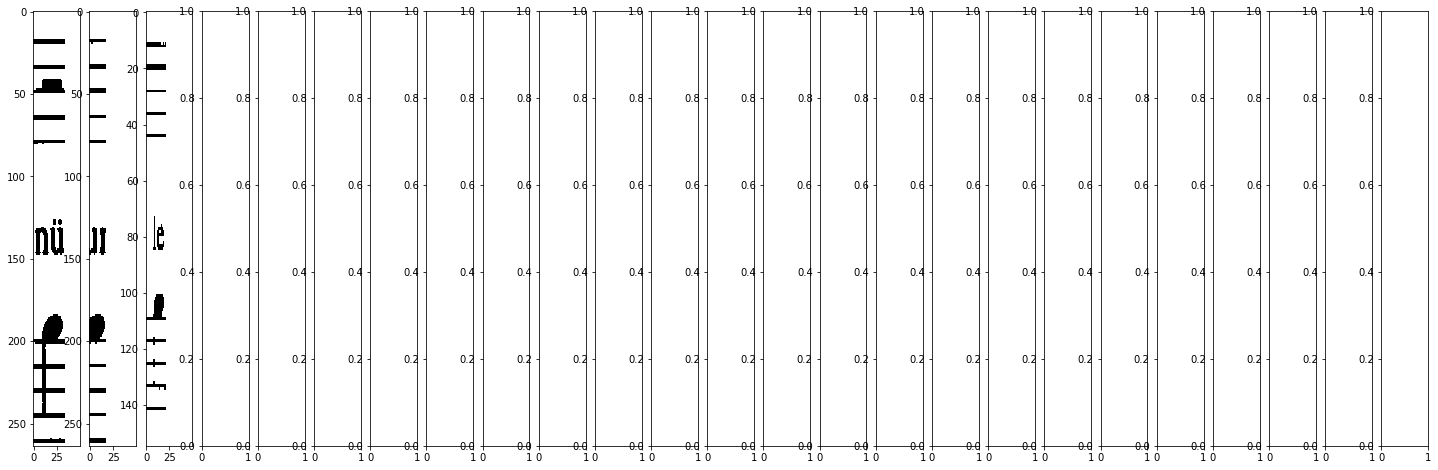

Cluster:  22


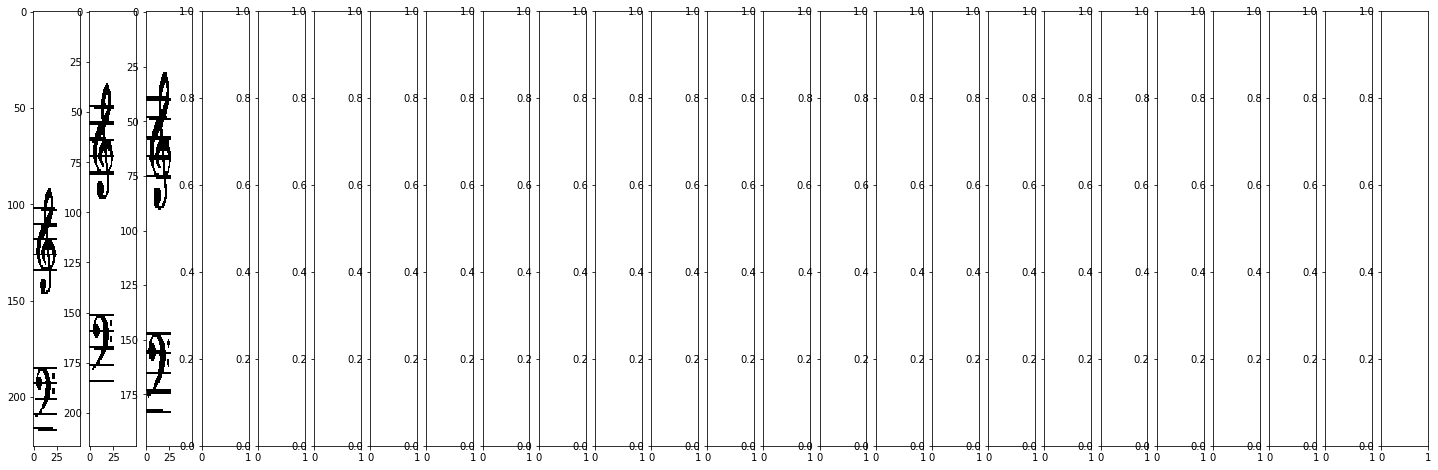

Cluster:  23


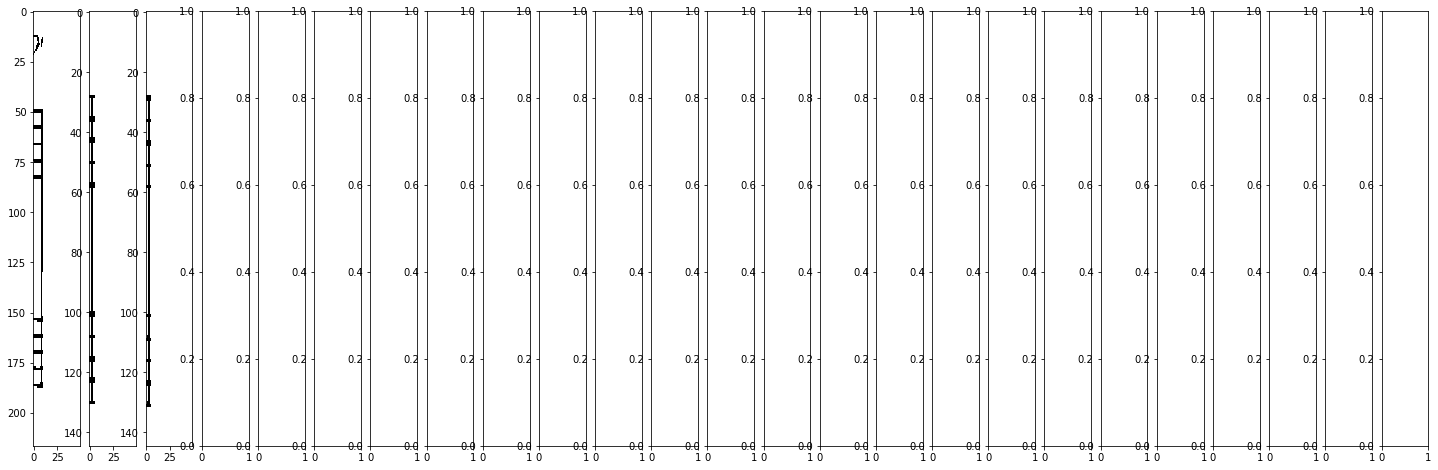

Cluster:  24


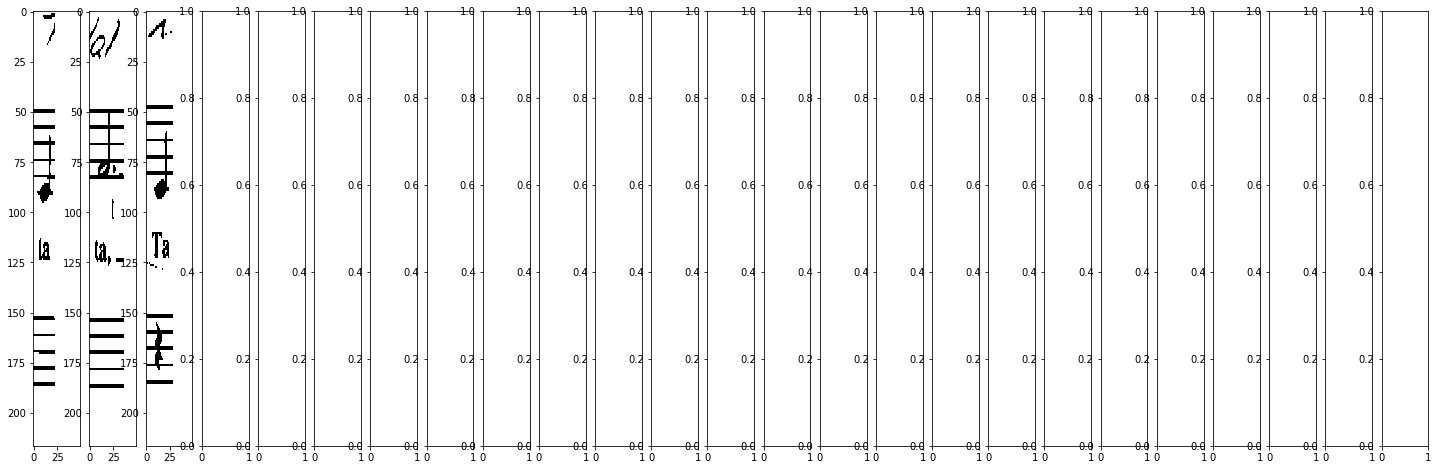

Cluster:  25


In [ ]:
# print cluster

c = 0
for lists in clusters.values():
    for items in lists:
        print ("Cluster: ", c)

        fig, axs = plt.subplots(1, num_entries, figsize=(num_entries,8))
    
        cnt = 0
        for item in items:
            if cnt < num_entries:
                img = Image.open (item)
                axs[cnt].imshow(img, aspect='auto', cmap="gray")
                cnt = cnt + 1
        plt.show()    
        c = c + 1

print ("Done!")